In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import os
import matplotlib.pyplot as plt
import torch
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:

def matrix_riccati_ode(t, S, H, M, D_inv, C):
    S = S.reshape((H.shape[0], H.shape[1]))
    dS_dt = -2 * H.T @ S + S @ M @ D_inv @ M.T @ S - C
    return dS_dt.reshape(-1)

class LQR:
    def __init__(self, H, M, sigma, C, R, D, T):
        self.H = H
        self.M = M
        self.sigma = sigma
        self.C = C
        self.R = R
        self.D = D
        self.T = T

    def solve(self, t, t_eval = None):
        D_inv = np.linalg.inv(self.D)
        if t == self.T:
            return None, None
        if t is None:
            t = 0
        if t_eval is None:
            t_eval = np.linspace(self.T, t, 101)
        sol = solve_ivp(matrix_riccati_ode, (self.T, t), self.R.reshape(-1), t_eval = t_eval, method='RK45', args=(self.H, self.M, D_inv, self.C))
        return sol.t, sol.y.reshape((-1, self.H.shape[0], self.H.shape[1]))  # Reshape solution to matrix form

    def getValue(self, ts, data):
        batch_size = data.shape[0]
        values = torch.zeros((batch_size, 1))
        for i in range(batch_size):
            t = ts[i]
            x = data[i][0].numpy()
            n = 101
            ts, sols = self.solve(t, np.linspace(self.T, t, n))
            values[i][0] = x.T @ sols[-1] @ x
            for sol in sols:
                values[i][0] += abs(self.T - t) / n * np.trace(self.sigma @ self.sigma.T @ sol)
        return values

    def getMarkovControl(self, ts, data):
        batch_size = data.shape[0]
        values = torch.zeros((batch_size, 2))
        for i in range(batch_size):
            t = ts[i]
            x = data[i][0].numpy()
            n = 101
            ts, sols = self.solve(t, np.linspace(self.T, t, n))
            values[i] = torch.from_numpy(-self.D @ self.M.T @ sols[-1] @ x)
        return values

    
    def runMonteCarlo(self, num_steps, num_samples, x):
        res = []
        dt = self.T / num_steps
        ts = np.linspace(0, self.T, num_steps)
        for i in range(num_samples):
            cur_x = np.array(x).reshape(-1,1)
            for j in range(num_steps - 1):
                increments = np.random.normal(0, 1, (1,2)).T
                _, S_tn = self.solve(ts[j])
                S_tn = S_tn[-1]
                cur_x = cur_x + dt * (self.H @ cur_x - self.M @ self.D @ S_tn @ cur_x) + self.sigma @ increments
            res.append(cur_x)
        return res


In [4]:
# Example usage:
H = np.array([[0, 1], [0, 0]])
M = np.array([[1, 0], [0, 1]])
D = np.array([[1, 0], [0, 1]])
T = 10
R = np.array([[1, 0], [0, 1]])
C = np.array([[0, 0], [0, 0]])
sigma = np.array([[0.2, 0], [0, 0.4]])
lqr = LQR(H, M, sigma, C, R, D, T)

t, p = lqr.solve(1, [10, 9, 8,7,6,5,4,3,2,1])

In [5]:
ts = torch.tensor([1, 2])
x = torch.tensor([[[2,1]], [[3,2]]])

In [6]:
print(t.shape)

(10,)


In [7]:
lqr.getValue(ts, x)

tensor([[ 1.5519],
        [22.9790]])

In [8]:
lqr.getMarkovControl(ts, x)

tensor([[-0.3080, -0.3024],
        [-4.5970, -4.5894]])

From the above code, we define the class LQR with attribute 'H, M, sigma, C, R, D, T', which is mentioned in the definition of LQR. The class has three methods - solve, getValue, getMarkovControl. 'Solve' will solve the associated Ricatti ODE on a time grid. 'getValue' will return the control problem value $v(t,x)$. 'getMarkovControl' will return the Markov control function.

We can choose MSE for error measure and we write following codes to show log-log plot.

In [9]:


# Set number of Monte Carlo samples
num_samples = 10**5

# Set different numbers of time steps to simulate
num_steps_list = [1, 10, 50, 100, 500, 1000, 5000]

# Initialize list to store MSE for each number of time steps
mse_list = []

# initial value of x
x = [1, 2]

# Loop over different numbers of time steps and compute MSE
for num_steps in num_steps_list:
    # Run Monte Carlo simulation
    # Here, we assume that the simulation returns the estimated value function as a numpy array
    # and the true value function as a dictionary with state-value pairs
    x_rets = lqr.runMonteCarlo(num_steps, num_samples, x)
    _, x_true = lqr.solve(0)
    x_true = x_true[-1]
    
    # Compute MSE
    mse = np.mean([np.linalg.norm(x_ret - x_true)**2 for x_ret in x_rets])
    
    # Append MSE to list
    mse_list.append(mse)


plt.loglog(num_steps_list, mse_list, '-o')
plt.xlabel('Number of time steps')
plt.ylabel('Mean squared error')
plt.show()


KeyboardInterrupt: 

In [ ]:
# Set number of Monte Carlo samples
num_samples_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

# Set different numbers of time steps to simulate
num_steps = 5000

# Initialize list to store MSE for each number of time steps
mse_list = []

# initial value of x
x = [1, 2]

# Loop over different numbers of time steps and compute MSE
for num_samples in num_samples_list:
    # Run Monte Carlo simulation
    # Here, we assume that the simulation returns the estimated value function as a numpy array
    # and the true value function as a dictionary with state-value pairs
    x_rets = lqr.runMonteCarlo(num_steps, num_samples, x)
    _, x_true = lqr.solve(0)
    x_true = x_true[-1]
    
    # Compute MSE
    mse = np.mean([np.linalg.norm(x_ret - x_true)**2 for x_ret in x_rets])
    
    # Append MSE to list
    mse_list.append(mse)


plt.loglog(num_steps_list, mse_list, '-o')
plt.xlabel('Number of samples')
plt.ylabel('Mean squared error')
plt.show()


Exercise 2

In [10]:
import torch
from torch import nn, optim
import numpy as np
from tqdm import tqdm

class DGM_Layer(nn.Module):
    
    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(DGM_Layer, self).__init__()
        
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))
            

        self.gate_Z = self.layer(dim_x+dim_S, dim_S)
        self.gate_G = self.layer(dim_x+dim_S, dim_S)
        self.gate_R = self.layer(dim_x+dim_S, dim_S)
        self.gate_H = self.layer(dim_x+dim_S, dim_S)
            
    def layer(self, nIn, nOut):
        l = nn.Sequential(nn.Linear(nIn, nOut), self.activation)
        return l
    
    def forward(self, x, S):
        x_S = torch.cat([x,S],1)
        Z = self.gate_Z(x_S)
        G = self.gate_G(x_S)
        R = self.gate_R(x_S)
        
        input_gate_H = torch.cat([x, S*R],1)
        H = self.gate_H(input_gate_H)
        
        output = ((1-G))*H + Z*S
        return output


class Net_DGM(nn.Module):

    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(Net_DGM, self).__init__()

        self.dim = dim_x
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))

        self.input_layer = nn.Sequential(nn.Linear(dim_x+1, dim_S), self.activation)

        self.DGM1 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM2 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM3 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)

        self.output_layer = nn.Linear(dim_S, 1)

    def forward(self,t,x):
        tx = torch.cat([t,x], 1)
        S1 = self.input_layer(tx)
        S2 = self.DGM1(tx,S1)
        S3 = self.DGM2(tx,S2)
        S4 = self.DGM3(tx,S3)
        output = self.output_layer(S4)
        return output


In [11]:
T = 1
hidden_size = 100
lr = 0.01
num_epochs = 10000

net = Net_DGM(2, hidden_size)
optimizer = optim.Adam(net.parameters(), lr=lr)
criterion = nn.MSELoss()

losses = []
for epoch in tqdm(range(num_epochs)):
    t = np.random.uniform(0, T)
    x = [np.random.uniform(-3, 3), np.random.uniform(-3, 3)]
    lqr = LQR(H, M, sigma, C, R, D, 1)
    y_true = torch.tensor(lqr.getValue(torch.tensor([t]), torch.tensor([[x]], dtype=torch.float32)))
    optimizer.zero_grad()
    y_pred = net(torch.tensor([[t]], dtype=torch.float32), torch.tensor([x]))
    loss = criterion(y_pred, y_true)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())


100%|██████████| 10000/10000 [01:57<00:00, 84.84it/s]


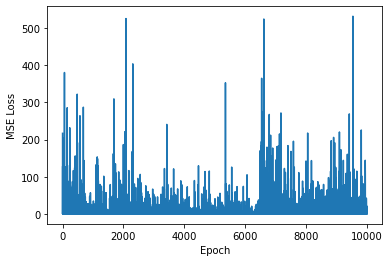

In [12]:
plt.plot(losses, '-')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

In [13]:
class FFN(nn.Module):

    def __init__(self, sizes, activation=nn.ReLU, output_activation=nn.Identity, batch_norm=False):
        super().__init__()
        
        layers = [nn.BatchNorm1d(sizes[0]),] if batch_norm else []
        for j in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[j], sizes[j+1]))
            if batch_norm:
                layers.append(nn.BatchNorm1d(sizes[j+1], affine=True))
            if j<(len(sizes)-2):
                layers.append(activation())
            else:
                layers.append(output_activation())

        self.net = nn.Sequential(*layers)

    def freeze(self):
        for p in self.parameters():
            p.requires_grad=False

    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad=True

    def forward(self, x):
        return self.net(x)

In [14]:
net = FFN([3, 100, 100, 2])
optimizer = optim.Adam(net.parameters(), lr=lr)
criterion = nn.MSELoss()

losses = []
for epoch in tqdm(range(num_epochs)):
    t = np.random.uniform(0, T)
    x = [np.random.uniform(-3, 3), np.random.uniform(-3, 3)]
    lqr = LQR(H, M, sigma, C, R, D, 1)
    y_true = torch.tensor(lqr.getValue(torch.tensor([t]), torch.tensor([[x]], dtype=torch.float32)))
    optimizer.zero_grad()
    tx = torch.cat([torch.tensor([[t]], dtype=torch.float32), torch.tensor([x])], 1)
    y_pred = net(tx)
    loss = criterion(y_pred, y_true)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|██████████| 10000/10000 [01:24<00:00, 118.16it/s]


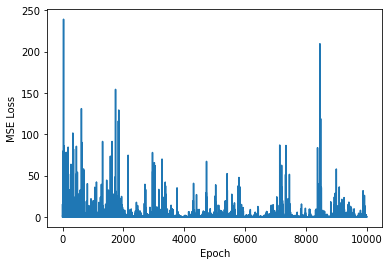

In [15]:
plt.plot(losses, '-')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

Exercise 3

In [16]:
def get_gradient(output, x):
    grad = torch.autograd.grad(output, x, grad_outputs=torch.ones_like(output), create_graph=True, retain_graph=True, only_inputs=True)[0]
    return grad

def get_laplacian(grad, x):
    hess = []
    for d in range(x.shape[1]):
        v = grad[:,d].view(-1,1)
        grad2 = torch.autograd.grad(v,x,grad_outputs=torch.ones_like(v), only_inputs=True, create_graph=True, retain_graph=True)[0]
        hess.append(grad2)
    return torch.cat(hess, 1)

class PDE_DGM(nn.Module):

    def __init__(self, d: int, hidden_dim: int, H, M, sigma, C, R, D, ts: torch.Tensor=None, device: str='cpu'):

        super().__init__()
        self.d = d
        self.net_dgm = Net_DGM(d, hidden_dim, activation='Tanh')
        self.H = torch.tensor(H, device=device)
        self.M = torch.tensor(M, device=device)
        self.sigma = torch.tensor(sigma, device=device)
        self.C = torch.tensor(C, device=device)
        self.R = torch.tensor(R, device=device)
        self.D = torch.tensor(D, device=device)
        self.alpha = torch.tensor([[1], [1]], device=device)
        self.ts = ts

    def fit(self, max_updates: int, batch_size: int, device):

        optimizer = torch.optim.Adam(self.net_dgm.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = (10000,),gamma=0.1)
        loss_fn = nn.MSELoss()
        
        pbar = tqdm(total=max_updates)
        loss_value = []
        for it in range(max_updates):
            optimizer.zero_grad()

            input_domain = 6 * torch.rand(batch_size, self.d, device=device, requires_grad=True) - 3
            t0, T = self.ts[0], self.ts[-1]
            t = t0 + T*torch.rand(batch_size, 1, device=device, requires_grad=True)
            t_T = torch.ones(batch_size, 1, device=device) * T
            u_of_tx = self.net_dgm(t, input_domain)
            u_of_Tx = self.net_dgm(t_T, input_domain)
            grad_u_x = get_gradient(u_of_tx,input_domain)
            grad_u_t = get_gradient(u_of_tx, t)
            laplacian = get_laplacian(grad_u_x, input_domain)
            target = torch.zeros_like(u_of_tx)
            R1, R2 = 0, 0
            eqn = []
            boundary = []
            for i in range(laplacian.shape[0]):
                x = laplacian[i]
                temp_x = x.cpu().detach().numpy().reshape(2,2)
                x_i = input_domain[i].cpu().detach().numpy()
                grad_u_x_i = grad_u_x[i].cpu().detach().numpy()
                alpha_np = self.alpha.cpu().numpy()
                temp_value = abs(grad_u_t[i].cpu().detach().numpy()
                         + 1/2*np.trace(self.sigma.cpu().numpy() @ self.sigma.cpu().numpy().T @ temp_x)
                         + grad_u_x_i.T @ self.H.cpu().numpy() @ x_i
                         + grad_u_x_i.T @ self.M.cpu().numpy() @ alpha_np
                         + grad_u_x_i.T @ self.M.cpu().numpy() @ alpha_np
                         + x_i.T @ self.C.cpu().numpy() @ x_i
                         + alpha_np.T @ self.D.cpu().numpy() @ alpha_np
                        )**2
                eqn.append(temp_value.tolist()[0])
                temp_value = abs(u_of_Tx[i].cpu().detach().numpy() - x_i.T @ self.R.cpu().numpy() @ x_i)**2
                boundary.append(temp_value.tolist()[0])
            eqn = torch.tensor(eqn, device=device, requires_grad = True)
            boundary = torch.tensor(boundary, device=device, requires_grad = True)
            MSE_eqn = loss_fn(eqn, target)
            MSE_boundary = loss_fn(boundary, target)

            loss = MSE_eqn + MSE_boundary
            loss_value.append(loss.cpu().detach().item())
            loss.backward()
            optimizer.step()
            scheduler.step()
            if it%10 == 0:
                pbar.update(10)
                pbar.write("Iteration: {}/{}\t MSE eqn: {:.4f}\t MSE boundary: {:.4f}\t Total Loss: {:.4f}".format(it, max_updates, MSE_eqn.item(), MSE_boundary.item(), loss.item()))
        plt.plot(loss_value, '-')
        plt.xlabel('Updates')
        plt.ylabel('MSE Loss')
        plt.show()

In [17]:
def train(T,
        n_steps,
        d,
        hidden_dim,
        max_updates,
        batch_size, 
        base_dir,
        device,
        ):
    
    logfile = os.path.join(base_dir, "log.txt")
    ts = torch.linspace(0,T,n_steps+1, device=device)
    pde_solver = PDE_DGM(d, hidden_dim, H, M, sigma, C, R, D, ts=ts, device=device)
    pde_solver.to(device)
    pde_solver.fit(max_updates=max_updates,
                     batch_size=batch_size, 
                     device=device)
    


In [18]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

  0%|          | 10/5000 [00:00<04:47, 17.34it/s]

Iteration: 0/5000	 MSE eqn: 11.8505	 MSE boundary: 5202.9175	 Total Loss: 5214.7681


  0%|          | 20/5000 [00:05<27:48,  2.98it/s]

Iteration: 10/5000	 MSE eqn: 11.6955	 MSE boundary: 7019.5146	 Total Loss: 7031.2100


  1%|          | 30/5000 [00:11<35:43,  2.32it/s]

Iteration: 20/5000	 MSE eqn: 11.8035	 MSE boundary: 5286.6064	 Total Loss: 5298.4102


  1%|          | 40/5000 [00:16<39:58,  2.07it/s]

Iteration: 30/5000	 MSE eqn: 11.7040	 MSE boundary: 5479.1909	 Total Loss: 5490.8950


  1%|          | 50/5000 [00:22<41:45,  1.98it/s]

Iteration: 40/5000	 MSE eqn: 11.7777	 MSE boundary: 5089.3506	 Total Loss: 5101.1284


  1%|          | 60/5000 [00:28<43:10,  1.91it/s]

Iteration: 50/5000	 MSE eqn: 11.9308	 MSE boundary: 6236.4570	 Total Loss: 6248.3877


  1%|▏         | 70/5000 [00:33<44:09,  1.86it/s]

Iteration: 60/5000	 MSE eqn: 11.7848	 MSE boundary: 5213.2236	 Total Loss: 5225.0083


  2%|▏         | 80/5000 [00:39<44:19,  1.85it/s]

Iteration: 70/5000	 MSE eqn: 11.8514	 MSE boundary: 5623.4907	 Total Loss: 5635.3423


  2%|▏         | 90/5000 [00:44<44:41,  1.83it/s]

Iteration: 80/5000	 MSE eqn: 11.8047	 MSE boundary: 4936.2314	 Total Loss: 4948.0361


  2%|▏         | 100/5000 [00:50<45:03,  1.81it/s]

Iteration: 90/5000	 MSE eqn: 11.6705	 MSE boundary: 5130.6396	 Total Loss: 5142.3101


  2%|▏         | 110/5000 [00:56<46:28,  1.75it/s]

Iteration: 100/5000	 MSE eqn: 11.8930	 MSE boundary: 5762.2139	 Total Loss: 5774.1069


  2%|▏         | 120/5000 [01:02<47:14,  1.72it/s]

Iteration: 110/5000	 MSE eqn: 11.6425	 MSE boundary: 5198.6045	 Total Loss: 5210.2471


  3%|▎         | 130/5000 [01:08<46:33,  1.74it/s]

Iteration: 120/5000	 MSE eqn: 11.6097	 MSE boundary: 5895.1099	 Total Loss: 5906.7197


  3%|▎         | 140/5000 [01:13<46:05,  1.76it/s]

Iteration: 130/5000	 MSE eqn: 11.7736	 MSE boundary: 6226.5103	 Total Loss: 6238.2837


  3%|▎         | 150/5000 [01:19<45:59,  1.76it/s]

Iteration: 140/5000	 MSE eqn: 11.8629	 MSE boundary: 5308.5557	 Total Loss: 5320.4185


  3%|▎         | 160/5000 [01:24<45:42,  1.76it/s]

Iteration: 150/5000	 MSE eqn: 11.8079	 MSE boundary: 6164.4355	 Total Loss: 6176.2437


  3%|▎         | 170/5000 [01:30<45:24,  1.77it/s]

Iteration: 160/5000	 MSE eqn: 11.7190	 MSE boundary: 5102.1855	 Total Loss: 5113.9048


  4%|▎         | 180/5000 [01:36<45:31,  1.76it/s]

Iteration: 170/5000	 MSE eqn: 11.5629	 MSE boundary: 5959.5444	 Total Loss: 5971.1074


  4%|▍         | 190/5000 [01:41<44:58,  1.78it/s]

Iteration: 180/5000	 MSE eqn: 11.9559	 MSE boundary: 4824.8623	 Total Loss: 4836.8184


  4%|▍         | 200/5000 [01:47<44:58,  1.78it/s]

Iteration: 190/5000	 MSE eqn: 11.7737	 MSE boundary: 6010.2549	 Total Loss: 6022.0288


  4%|▍         | 210/5000 [01:53<45:06,  1.77it/s]

Iteration: 200/5000	 MSE eqn: 11.6272	 MSE boundary: 6575.3257	 Total Loss: 6586.9531


  4%|▍         | 220/5000 [01:58<44:44,  1.78it/s]

Iteration: 210/5000	 MSE eqn: 11.7317	 MSE boundary: 5820.7417	 Total Loss: 5832.4731


  5%|▍         | 230/5000 [02:04<44:33,  1.78it/s]

Iteration: 220/5000	 MSE eqn: 11.7866	 MSE boundary: 6209.9600	 Total Loss: 6221.7466


  5%|▍         | 240/5000 [02:09<44:41,  1.77it/s]

Iteration: 230/5000	 MSE eqn: 11.7566	 MSE boundary: 6574.3696	 Total Loss: 6586.1265


  5%|▌         | 250/5000 [02:15<44:23,  1.78it/s]

Iteration: 240/5000	 MSE eqn: 11.9142	 MSE boundary: 6460.3247	 Total Loss: 6472.2388


  5%|▌         | 260/5000 [02:21<44:15,  1.79it/s]

Iteration: 250/5000	 MSE eqn: 11.6458	 MSE boundary: 4748.1733	 Total Loss: 4759.8193


  5%|▌         | 270/5000 [02:26<44:16,  1.78it/s]

Iteration: 260/5000	 MSE eqn: 11.7266	 MSE boundary: 6369.3423	 Total Loss: 6381.0688


  6%|▌         | 280/5000 [02:32<44:02,  1.79it/s]

Iteration: 270/5000	 MSE eqn: 11.9211	 MSE boundary: 5491.1089	 Total Loss: 5503.0298


  6%|▌         | 290/5000 [02:38<44:15,  1.77it/s]

Iteration: 280/5000	 MSE eqn: 11.7405	 MSE boundary: 6026.4844	 Total Loss: 6038.2251


  6%|▌         | 300/5000 [02:43<44:05,  1.78it/s]

Iteration: 290/5000	 MSE eqn: 11.7481	 MSE boundary: 5654.9443	 Total Loss: 5666.6924


  6%|▌         | 310/5000 [02:49<43:55,  1.78it/s]

Iteration: 300/5000	 MSE eqn: 11.7662	 MSE boundary: 5797.5737	 Total Loss: 5809.3398


  6%|▋         | 320/5000 [02:55<44:55,  1.74it/s]

Iteration: 310/5000	 MSE eqn: 11.7915	 MSE boundary: 5933.7510	 Total Loss: 5945.5425


  7%|▋         | 330/5000 [03:01<44:50,  1.74it/s]

Iteration: 320/5000	 MSE eqn: 11.8835	 MSE boundary: 4653.9058	 Total Loss: 4665.7891


  7%|▋         | 340/5000 [03:06<44:08,  1.76it/s]

Iteration: 330/5000	 MSE eqn: 11.9195	 MSE boundary: 4816.6152	 Total Loss: 4828.5347


  7%|▋         | 350/5000 [03:12<44:14,  1.75it/s]

Iteration: 340/5000	 MSE eqn: 11.8380	 MSE boundary: 5352.5693	 Total Loss: 5364.4072


  7%|▋         | 360/5000 [03:17<43:49,  1.76it/s]

Iteration: 350/5000	 MSE eqn: 11.8664	 MSE boundary: 6047.0811	 Total Loss: 6058.9473


  7%|▋         | 370/5000 [03:23<43:10,  1.79it/s]

Iteration: 360/5000	 MSE eqn: 11.7653	 MSE boundary: 6004.5537	 Total Loss: 6016.3188


  8%|▊         | 380/5000 [03:29<43:23,  1.77it/s]

Iteration: 370/5000	 MSE eqn: 11.7796	 MSE boundary: 6170.5278	 Total Loss: 6182.3076


  8%|▊         | 390/5000 [03:34<42:49,  1.79it/s]

Iteration: 380/5000	 MSE eqn: 11.7650	 MSE boundary: 6081.1377	 Total Loss: 6092.9028


  8%|▊         | 400/5000 [03:39<42:21,  1.81it/s]

Iteration: 390/5000	 MSE eqn: 11.7748	 MSE boundary: 6345.8423	 Total Loss: 6357.6172


  8%|▊         | 410/5000 [03:45<42:25,  1.80it/s]

Iteration: 400/5000	 MSE eqn: 11.8764	 MSE boundary: 5590.1855	 Total Loss: 5602.0620


  8%|▊         | 420/5000 [03:50<42:03,  1.82it/s]

Iteration: 410/5000	 MSE eqn: 11.8936	 MSE boundary: 5732.9756	 Total Loss: 5744.8691


  9%|▊         | 430/5000 [03:56<41:50,  1.82it/s]

Iteration: 420/5000	 MSE eqn: 11.7263	 MSE boundary: 5650.3867	 Total Loss: 5662.1128


  9%|▉         | 440/5000 [04:02<42:25,  1.79it/s]

Iteration: 430/5000	 MSE eqn: 11.6351	 MSE boundary: 5265.0762	 Total Loss: 5276.7114


  9%|▉         | 450/5000 [04:07<41:59,  1.81it/s]

Iteration: 440/5000	 MSE eqn: 11.7669	 MSE boundary: 5634.9663	 Total Loss: 5646.7334


  9%|▉         | 460/5000 [04:13<42:13,  1.79it/s]

Iteration: 450/5000	 MSE eqn: 11.6429	 MSE boundary: 5332.9932	 Total Loss: 5344.6362


  9%|▉         | 470/5000 [04:18<41:48,  1.81it/s]

Iteration: 460/5000	 MSE eqn: 11.6147	 MSE boundary: 5314.1069	 Total Loss: 5325.7217


 10%|▉         | 480/5000 [04:24<41:27,  1.82it/s]

Iteration: 470/5000	 MSE eqn: 11.6990	 MSE boundary: 6365.0288	 Total Loss: 6376.7280


 10%|▉         | 490/5000 [04:29<41:33,  1.81it/s]

Iteration: 480/5000	 MSE eqn: 11.7022	 MSE boundary: 5752.3193	 Total Loss: 5764.0215


 10%|█         | 500/5000 [04:35<41:14,  1.82it/s]

Iteration: 490/5000	 MSE eqn: 11.7742	 MSE boundary: 5783.1069	 Total Loss: 5794.8813


 10%|█         | 510/5000 [04:40<41:09,  1.82it/s]

Iteration: 500/5000	 MSE eqn: 11.8307	 MSE boundary: 5995.7881	 Total Loss: 6007.6187


 10%|█         | 520/5000 [04:46<41:29,  1.80it/s]

Iteration: 510/5000	 MSE eqn: 11.6974	 MSE boundary: 5789.5166	 Total Loss: 5801.2139


 11%|█         | 530/5000 [04:51<41:25,  1.80it/s]

Iteration: 520/5000	 MSE eqn: 11.7267	 MSE boundary: 5145.9067	 Total Loss: 5157.6333


 11%|█         | 540/5000 [04:57<41:56,  1.77it/s]

Iteration: 530/5000	 MSE eqn: 11.8692	 MSE boundary: 5666.9912	 Total Loss: 5678.8604


 11%|█         | 550/5000 [05:03<41:44,  1.78it/s]

Iteration: 540/5000	 MSE eqn: 11.6806	 MSE boundary: 5120.1895	 Total Loss: 5131.8701


 11%|█         | 560/5000 [05:08<41:27,  1.78it/s]

Iteration: 550/5000	 MSE eqn: 11.7213	 MSE boundary: 6022.6997	 Total Loss: 6034.4209


 11%|█▏        | 570/5000 [05:14<41:05,  1.80it/s]

Iteration: 560/5000	 MSE eqn: 11.6099	 MSE boundary: 5661.5967	 Total Loss: 5673.2065


 12%|█▏        | 580/5000 [05:20<41:15,  1.79it/s]

Iteration: 570/5000	 MSE eqn: 11.6238	 MSE boundary: 4854.5840	 Total Loss: 4866.2080


 12%|█▏        | 590/5000 [05:25<41:00,  1.79it/s]

Iteration: 580/5000	 MSE eqn: 11.5849	 MSE boundary: 6883.3120	 Total Loss: 6894.8970


 12%|█▏        | 600/5000 [05:31<41:18,  1.78it/s]

Iteration: 590/5000	 MSE eqn: 11.8610	 MSE boundary: 5405.5347	 Total Loss: 5417.3955


 12%|█▏        | 610/5000 [05:37<41:17,  1.77it/s]

Iteration: 600/5000	 MSE eqn: 11.9606	 MSE boundary: 6993.1431	 Total Loss: 7005.1035


 12%|█▏        | 620/5000 [05:42<40:54,  1.78it/s]

Iteration: 610/5000	 MSE eqn: 11.7868	 MSE boundary: 6516.4375	 Total Loss: 6528.2241


 13%|█▎        | 630/5000 [05:48<40:38,  1.79it/s]

Iteration: 620/5000	 MSE eqn: 11.7912	 MSE boundary: 5316.9004	 Total Loss: 5328.6914


 13%|█▎        | 640/5000 [05:53<40:36,  1.79it/s]

Iteration: 630/5000	 MSE eqn: 11.7989	 MSE boundary: 5960.6631	 Total Loss: 5972.4619


 13%|█▎        | 650/5000 [05:59<40:08,  1.81it/s]

Iteration: 640/5000	 MSE eqn: 11.7245	 MSE boundary: 6092.2690	 Total Loss: 6103.9937


 13%|█▎        | 660/5000 [06:04<39:57,  1.81it/s]

Iteration: 650/5000	 MSE eqn: 11.7330	 MSE boundary: 6322.5044	 Total Loss: 6334.2373


 13%|█▎        | 670/5000 [06:10<40:04,  1.80it/s]

Iteration: 660/5000	 MSE eqn: 11.8430	 MSE boundary: 5313.7480	 Total Loss: 5325.5913


 14%|█▎        | 680/5000 [06:15<39:55,  1.80it/s]

Iteration: 670/5000	 MSE eqn: 11.8918	 MSE boundary: 5627.4116	 Total Loss: 5639.3032


 14%|█▍        | 690/5000 [06:21<39:55,  1.80it/s]

Iteration: 680/5000	 MSE eqn: 11.7778	 MSE boundary: 4577.2026	 Total Loss: 4588.9805


 14%|█▍        | 700/5000 [06:26<39:42,  1.80it/s]

Iteration: 690/5000	 MSE eqn: 11.7383	 MSE boundary: 4884.4727	 Total Loss: 4896.2109


 14%|█▍        | 710/5000 [06:32<39:20,  1.82it/s]

Iteration: 700/5000	 MSE eqn: 11.7149	 MSE boundary: 6055.7539	 Total Loss: 6067.4688


 14%|█▍        | 720/5000 [06:37<39:41,  1.80it/s]

Iteration: 710/5000	 MSE eqn: 11.8122	 MSE boundary: 6101.9824	 Total Loss: 6113.7944


 15%|█▍        | 730/5000 [06:43<39:31,  1.80it/s]

Iteration: 720/5000	 MSE eqn: 11.7053	 MSE boundary: 5893.9292	 Total Loss: 5905.6343


 15%|█▍        | 740/5000 [06:48<39:18,  1.81it/s]

Iteration: 730/5000	 MSE eqn: 11.6749	 MSE boundary: 6261.1465	 Total Loss: 6272.8213


 15%|█▌        | 750/5000 [06:54<40:14,  1.76it/s]

Iteration: 740/5000	 MSE eqn: 11.8504	 MSE boundary: 5467.7642	 Total Loss: 5479.6147


 15%|█▌        | 760/5000 [07:00<40:42,  1.74it/s]

Iteration: 750/5000	 MSE eqn: 11.7333	 MSE boundary: 6250.1943	 Total Loss: 6261.9277


 15%|█▌        | 770/5000 [07:06<40:04,  1.76it/s]

Iteration: 760/5000	 MSE eqn: 11.7327	 MSE boundary: 5305.6929	 Total Loss: 5317.4258


 16%|█▌        | 780/5000 [07:12<39:57,  1.76it/s]

Iteration: 770/5000	 MSE eqn: 11.7585	 MSE boundary: 5804.0078	 Total Loss: 5815.7661


 16%|█▌        | 790/5000 [07:17<39:26,  1.78it/s]

Iteration: 780/5000	 MSE eqn: 11.7217	 MSE boundary: 5769.7720	 Total Loss: 5781.4937


 16%|█▌        | 800/5000 [07:23<38:57,  1.80it/s]

Iteration: 790/5000	 MSE eqn: 11.7625	 MSE boundary: 5922.6016	 Total Loss: 5934.3643


 16%|█▌        | 810/5000 [07:28<39:03,  1.79it/s]

Iteration: 800/5000	 MSE eqn: 11.7097	 MSE boundary: 6164.5874	 Total Loss: 6176.2969


 16%|█▋        | 820/5000 [07:34<38:43,  1.80it/s]

Iteration: 810/5000	 MSE eqn: 11.8067	 MSE boundary: 5928.0488	 Total Loss: 5939.8555


 17%|█▋        | 830/5000 [07:39<38:30,  1.80it/s]

Iteration: 820/5000	 MSE eqn: 11.7227	 MSE boundary: 5716.3599	 Total Loss: 5728.0825


 17%|█▋        | 840/5000 [07:45<38:36,  1.80it/s]

Iteration: 830/5000	 MSE eqn: 11.8200	 MSE boundary: 4871.3525	 Total Loss: 4883.1724


 17%|█▋        | 850/5000 [07:50<38:37,  1.79it/s]

Iteration: 840/5000	 MSE eqn: 11.7451	 MSE boundary: 6390.8345	 Total Loss: 6402.5796


 17%|█▋        | 860/5000 [07:56<38:26,  1.79it/s]

Iteration: 850/5000	 MSE eqn: 11.8249	 MSE boundary: 5946.1812	 Total Loss: 5958.0059


 17%|█▋        | 870/5000 [08:01<38:12,  1.80it/s]

Iteration: 860/5000	 MSE eqn: 11.9059	 MSE boundary: 6066.4219	 Total Loss: 6078.3276


 18%|█▊        | 880/5000 [08:07<37:56,  1.81it/s]

Iteration: 870/5000	 MSE eqn: 11.9245	 MSE boundary: 5242.3325	 Total Loss: 5254.2568


 18%|█▊        | 890/5000 [08:12<37:50,  1.81it/s]

Iteration: 880/5000	 MSE eqn: 11.7049	 MSE boundary: 7026.1841	 Total Loss: 7037.8892


 18%|█▊        | 900/5000 [08:18<37:42,  1.81it/s]

Iteration: 890/5000	 MSE eqn: 11.8349	 MSE boundary: 5776.6548	 Total Loss: 5788.4897


 18%|█▊        | 910/5000 [08:23<37:26,  1.82it/s]

Iteration: 900/5000	 MSE eqn: 11.8470	 MSE boundary: 5863.2720	 Total Loss: 5875.1191


 18%|█▊        | 920/5000 [08:29<37:23,  1.82it/s]

Iteration: 910/5000	 MSE eqn: 11.7106	 MSE boundary: 5656.6763	 Total Loss: 5668.3867


 19%|█▊        | 930/5000 [08:34<37:07,  1.83it/s]

Iteration: 920/5000	 MSE eqn: 11.7291	 MSE boundary: 6219.9268	 Total Loss: 6231.6558


 19%|█▉        | 940/5000 [08:40<37:00,  1.83it/s]

Iteration: 930/5000	 MSE eqn: 11.7472	 MSE boundary: 6062.7686	 Total Loss: 6074.5156


 19%|█▉        | 950/5000 [08:45<37:16,  1.81it/s]

Iteration: 940/5000	 MSE eqn: 11.8148	 MSE boundary: 4983.6006	 Total Loss: 4995.4155


 19%|█▉        | 960/5000 [08:51<37:09,  1.81it/s]

Iteration: 950/5000	 MSE eqn: 11.7895	 MSE boundary: 5559.8726	 Total Loss: 5571.6621


 19%|█▉        | 970/5000 [08:57<37:57,  1.77it/s]

Iteration: 960/5000	 MSE eqn: 11.8765	 MSE boundary: 4965.0679	 Total Loss: 4976.9443


 20%|█▉        | 980/5000 [09:03<38:13,  1.75it/s]

Iteration: 970/5000	 MSE eqn: 11.7906	 MSE boundary: 5623.0854	 Total Loss: 5634.8760


 20%|█▉        | 990/5000 [09:08<37:52,  1.76it/s]

Iteration: 980/5000	 MSE eqn: 11.8326	 MSE boundary: 6500.2920	 Total Loss: 6512.1245


 20%|██        | 1000/5000 [09:14<37:17,  1.79it/s]

Iteration: 990/5000	 MSE eqn: 11.7101	 MSE boundary: 5596.7422	 Total Loss: 5608.4521


 20%|██        | 1010/5000 [09:19<37:02,  1.80it/s]

Iteration: 1000/5000	 MSE eqn: 11.7258	 MSE boundary: 5835.7920	 Total Loss: 5847.5181


 20%|██        | 1020/5000 [09:25<36:40,  1.81it/s]

Iteration: 1010/5000	 MSE eqn: 11.6868	 MSE boundary: 6174.9736	 Total Loss: 6186.6606


 21%|██        | 1030/5000 [09:30<36:23,  1.82it/s]

Iteration: 1020/5000	 MSE eqn: 11.9046	 MSE boundary: 5910.7729	 Total Loss: 5922.6777


 21%|██        | 1040/5000 [09:36<36:17,  1.82it/s]

Iteration: 1030/5000	 MSE eqn: 11.6503	 MSE boundary: 6019.8901	 Total Loss: 6031.5405


 21%|██        | 1050/5000 [09:41<36:20,  1.81it/s]

Iteration: 1040/5000	 MSE eqn: 11.7526	 MSE boundary: 5610.8667	 Total Loss: 5622.6191


 21%|██        | 1060/5000 [09:47<36:08,  1.82it/s]

Iteration: 1050/5000	 MSE eqn: 11.8452	 MSE boundary: 6012.7954	 Total Loss: 6024.6406


 21%|██▏       | 1070/5000 [09:52<36:26,  1.80it/s]

Iteration: 1060/5000	 MSE eqn: 11.8495	 MSE boundary: 5739.5801	 Total Loss: 5751.4297


 22%|██▏       | 1080/5000 [09:58<36:03,  1.81it/s]

Iteration: 1070/5000	 MSE eqn: 11.6221	 MSE boundary: 5768.2432	 Total Loss: 5779.8652


 22%|██▏       | 1090/5000 [10:03<35:50,  1.82it/s]

Iteration: 1080/5000	 MSE eqn: 11.8566	 MSE boundary: 6139.8906	 Total Loss: 6151.7471


 22%|██▏       | 1100/5000 [10:09<35:54,  1.81it/s]

Iteration: 1090/5000	 MSE eqn: 11.8661	 MSE boundary: 4952.6392	 Total Loss: 4964.5054


 22%|██▏       | 1110/5000 [10:14<35:40,  1.82it/s]

Iteration: 1100/5000	 MSE eqn: 11.8214	 MSE boundary: 5428.4780	 Total Loss: 5440.2993


 22%|██▏       | 1120/5000 [10:20<35:32,  1.82it/s]

Iteration: 1110/5000	 MSE eqn: 11.6054	 MSE boundary: 5466.5469	 Total Loss: 5478.1523


 23%|██▎       | 1130/5000 [10:25<35:44,  1.80it/s]

Iteration: 1120/5000	 MSE eqn: 11.6271	 MSE boundary: 6376.6616	 Total Loss: 6388.2886


 23%|██▎       | 1140/5000 [10:31<35:25,  1.82it/s]

Iteration: 1130/5000	 MSE eqn: 11.9452	 MSE boundary: 6154.0791	 Total Loss: 6166.0244


 23%|██▎       | 1150/5000 [10:36<35:39,  1.80it/s]

Iteration: 1140/5000	 MSE eqn: 11.8903	 MSE boundary: 5489.1792	 Total Loss: 5501.0693


 23%|██▎       | 1160/5000 [10:42<35:25,  1.81it/s]

Iteration: 1150/5000	 MSE eqn: 11.8937	 MSE boundary: 6584.2646	 Total Loss: 6596.1582


 23%|██▎       | 1170/5000 [10:47<35:06,  1.82it/s]

Iteration: 1160/5000	 MSE eqn: 11.7706	 MSE boundary: 6997.3647	 Total Loss: 7009.1353


 24%|██▎       | 1180/5000 [10:53<35:44,  1.78it/s]

Iteration: 1170/5000	 MSE eqn: 11.7954	 MSE boundary: 5704.3682	 Total Loss: 5716.1636


 24%|██▍       | 1190/5000 [10:59<36:02,  1.76it/s]

Iteration: 1180/5000	 MSE eqn: 11.6749	 MSE boundary: 5712.1216	 Total Loss: 5723.7964


 24%|██▍       | 1200/5000 [11:05<35:41,  1.77it/s]

Iteration: 1190/5000	 MSE eqn: 11.8064	 MSE boundary: 5836.7476	 Total Loss: 5848.5542


 24%|██▍       | 1210/5000 [11:10<35:33,  1.78it/s]

Iteration: 1200/5000	 MSE eqn: 11.7375	 MSE boundary: 6320.5059	 Total Loss: 6332.2432


 24%|██▍       | 1220/5000 [11:16<35:07,  1.79it/s]

Iteration: 1210/5000	 MSE eqn: 11.7477	 MSE boundary: 5097.1475	 Total Loss: 5108.8950


 25%|██▍       | 1230/5000 [11:21<34:58,  1.80it/s]

Iteration: 1220/5000	 MSE eqn: 11.6984	 MSE boundary: 6600.4380	 Total Loss: 6612.1362


 25%|██▍       | 1240/5000 [11:27<35:01,  1.79it/s]

Iteration: 1230/5000	 MSE eqn: 11.7500	 MSE boundary: 4799.5259	 Total Loss: 4811.2759


 25%|██▌       | 1250/5000 [11:32<34:49,  1.79it/s]

Iteration: 1240/5000	 MSE eqn: 11.7276	 MSE boundary: 6343.3159	 Total Loss: 6355.0435


 25%|██▌       | 1260/5000 [11:38<34:21,  1.81it/s]

Iteration: 1250/5000	 MSE eqn: 11.7801	 MSE boundary: 5741.1431	 Total Loss: 5752.9233


 25%|██▌       | 1270/5000 [11:43<34:32,  1.80it/s]

Iteration: 1260/5000	 MSE eqn: 11.8929	 MSE boundary: 4849.3130	 Total Loss: 4861.2061


 26%|██▌       | 1280/5000 [11:49<34:33,  1.79it/s]

Iteration: 1270/5000	 MSE eqn: 11.7484	 MSE boundary: 5366.2695	 Total Loss: 5378.0181


 26%|██▌       | 1290/5000 [11:54<34:12,  1.81it/s]

Iteration: 1280/5000	 MSE eqn: 11.9433	 MSE boundary: 5865.4058	 Total Loss: 5877.3491


 26%|██▌       | 1300/5000 [12:00<34:23,  1.79it/s]

Iteration: 1290/5000	 MSE eqn: 11.7141	 MSE boundary: 6109.0625	 Total Loss: 6120.7769


 26%|██▌       | 1310/5000 [12:06<34:01,  1.81it/s]

Iteration: 1300/5000	 MSE eqn: 11.7718	 MSE boundary: 5417.6133	 Total Loss: 5429.3853


 26%|██▋       | 1320/5000 [12:11<33:56,  1.81it/s]

Iteration: 1310/5000	 MSE eqn: 11.9361	 MSE boundary: 5495.9580	 Total Loss: 5507.8940


 27%|██▋       | 1330/5000 [12:17<34:14,  1.79it/s]

Iteration: 1320/5000	 MSE eqn: 11.6972	 MSE boundary: 5838.4434	 Total Loss: 5850.1406


 27%|██▋       | 1340/5000 [12:22<33:51,  1.80it/s]

Iteration: 1330/5000	 MSE eqn: 11.7807	 MSE boundary: 5458.4727	 Total Loss: 5470.2534


 27%|██▋       | 1350/5000 [12:28<33:26,  1.82it/s]

Iteration: 1340/5000	 MSE eqn: 11.7533	 MSE boundary: 5357.7827	 Total Loss: 5369.5361


 27%|██▋       | 1360/5000 [12:33<33:34,  1.81it/s]

Iteration: 1350/5000	 MSE eqn: 11.6631	 MSE boundary: 5286.6304	 Total Loss: 5298.2935


 27%|██▋       | 1370/5000 [12:39<33:16,  1.82it/s]

Iteration: 1360/5000	 MSE eqn: 11.7922	 MSE boundary: 5454.2314	 Total Loss: 5466.0234


 28%|██▊       | 1380/5000 [12:44<33:11,  1.82it/s]

Iteration: 1370/5000	 MSE eqn: 11.7249	 MSE boundary: 5119.5166	 Total Loss: 5131.2417


 28%|██▊       | 1390/5000 [12:50<33:17,  1.81it/s]

Iteration: 1380/5000	 MSE eqn: 11.8750	 MSE boundary: 5192.3745	 Total Loss: 5204.2495


 28%|██▊       | 1400/5000 [12:56<34:04,  1.76it/s]

Iteration: 1390/5000	 MSE eqn: 11.8265	 MSE boundary: 5262.7832	 Total Loss: 5274.6099


 28%|██▊       | 1410/5000 [13:02<33:56,  1.76it/s]

Iteration: 1400/5000	 MSE eqn: 11.7722	 MSE boundary: 5900.4141	 Total Loss: 5912.1860


 28%|██▊       | 1420/5000 [13:07<33:37,  1.77it/s]

Iteration: 1410/5000	 MSE eqn: 11.8121	 MSE boundary: 5279.3042	 Total Loss: 5291.1162


 29%|██▊       | 1430/5000 [13:12<33:07,  1.80it/s]

Iteration: 1420/5000	 MSE eqn: 11.7643	 MSE boundary: 5808.5806	 Total Loss: 5820.3447


 29%|██▉       | 1440/5000 [13:18<33:07,  1.79it/s]

Iteration: 1430/5000	 MSE eqn: 11.6526	 MSE boundary: 6570.2261	 Total Loss: 6581.8789


 29%|██▉       | 1450/5000 [13:24<32:55,  1.80it/s]

Iteration: 1440/5000	 MSE eqn: 11.8137	 MSE boundary: 5754.7529	 Total Loss: 5766.5669


 29%|██▉       | 1460/5000 [13:29<32:36,  1.81it/s]

Iteration: 1450/5000	 MSE eqn: 11.6938	 MSE boundary: 6437.4839	 Total Loss: 6449.1777


 29%|██▉       | 1470/5000 [13:35<32:40,  1.80it/s]

Iteration: 1460/5000	 MSE eqn: 11.9347	 MSE boundary: 5438.6904	 Total Loss: 5450.6250


 30%|██▉       | 1480/5000 [13:40<32:23,  1.81it/s]

Iteration: 1470/5000	 MSE eqn: 11.7131	 MSE boundary: 6015.6353	 Total Loss: 6027.3481


 30%|██▉       | 1490/5000 [13:46<32:10,  1.82it/s]

Iteration: 1480/5000	 MSE eqn: 11.8083	 MSE boundary: 5514.4644	 Total Loss: 5526.2725


 30%|███       | 1500/5000 [13:51<32:08,  1.82it/s]

Iteration: 1490/5000	 MSE eqn: 11.6722	 MSE boundary: 5230.7583	 Total Loss: 5242.4307


 30%|███       | 1510/5000 [13:57<31:54,  1.82it/s]

Iteration: 1500/5000	 MSE eqn: 11.6883	 MSE boundary: 6356.9160	 Total Loss: 6368.6045


 30%|███       | 1520/5000 [14:02<31:53,  1.82it/s]

Iteration: 1510/5000	 MSE eqn: 11.8710	 MSE boundary: 5307.6875	 Total Loss: 5319.5586


 31%|███       | 1530/5000 [14:08<32:00,  1.81it/s]

Iteration: 1520/5000	 MSE eqn: 11.6723	 MSE boundary: 6192.5063	 Total Loss: 6204.1787


 31%|███       | 1540/5000 [14:13<31:43,  1.82it/s]

Iteration: 1530/5000	 MSE eqn: 11.6006	 MSE boundary: 5851.8120	 Total Loss: 5863.4126


 31%|███       | 1550/5000 [14:19<31:37,  1.82it/s]

Iteration: 1540/5000	 MSE eqn: 11.7305	 MSE boundary: 5794.4302	 Total Loss: 5806.1606


 31%|███       | 1560/5000 [14:24<31:53,  1.80it/s]

Iteration: 1550/5000	 MSE eqn: 11.7577	 MSE boundary: 5808.3286	 Total Loss: 5820.0864


 31%|███▏      | 1570/5000 [14:30<31:33,  1.81it/s]

Iteration: 1560/5000	 MSE eqn: 11.8012	 MSE boundary: 5598.4614	 Total Loss: 5610.2627


 32%|███▏      | 1580/5000 [14:35<31:20,  1.82it/s]

Iteration: 1570/5000	 MSE eqn: 11.6835	 MSE boundary: 5510.8740	 Total Loss: 5522.5576


 32%|███▏      | 1590/5000 [14:41<31:39,  1.80it/s]

Iteration: 1580/5000	 MSE eqn: 11.7859	 MSE boundary: 4963.6997	 Total Loss: 4975.4858


 32%|███▏      | 1600/5000 [14:46<31:28,  1.80it/s]

Iteration: 1590/5000	 MSE eqn: 11.7727	 MSE boundary: 5040.4922	 Total Loss: 5052.2646


 32%|███▏      | 1610/5000 [14:52<31:24,  1.80it/s]

Iteration: 1600/5000	 MSE eqn: 11.6217	 MSE boundary: 5522.7148	 Total Loss: 5534.3364


 32%|███▏      | 1620/5000 [14:58<32:19,  1.74it/s]

Iteration: 1610/5000	 MSE eqn: 11.7696	 MSE boundary: 5247.3418	 Total Loss: 5259.1113


 33%|███▎      | 1630/5000 [15:04<31:50,  1.76it/s]

Iteration: 1620/5000	 MSE eqn: 11.7227	 MSE boundary: 5497.8911	 Total Loss: 5509.6138


 33%|███▎      | 1640/5000 [15:09<31:40,  1.77it/s]

Iteration: 1630/5000	 MSE eqn: 11.7207	 MSE boundary: 5617.0474	 Total Loss: 5628.7681


 33%|███▎      | 1650/5000 [15:15<31:13,  1.79it/s]

Iteration: 1640/5000	 MSE eqn: 11.7834	 MSE boundary: 6573.1763	 Total Loss: 6584.9595


 33%|███▎      | 1660/5000 [15:20<30:55,  1.80it/s]

Iteration: 1650/5000	 MSE eqn: 11.6970	 MSE boundary: 5821.4448	 Total Loss: 5833.1416


 33%|███▎      | 1670/5000 [15:26<30:52,  1.80it/s]

Iteration: 1660/5000	 MSE eqn: 11.7739	 MSE boundary: 5586.4814	 Total Loss: 5598.2554


 34%|███▎      | 1680/5000 [15:31<30:57,  1.79it/s]

Iteration: 1670/5000	 MSE eqn: 11.8740	 MSE boundary: 5595.1431	 Total Loss: 5607.0171


 34%|███▍      | 1690/5000 [15:37<30:42,  1.80it/s]

Iteration: 1680/5000	 MSE eqn: 11.7018	 MSE boundary: 5428.8823	 Total Loss: 5440.5840


 34%|███▍      | 1700/5000 [15:43<30:39,  1.79it/s]

Iteration: 1690/5000	 MSE eqn: 11.7165	 MSE boundary: 6601.9668	 Total Loss: 6613.6831


 34%|███▍      | 1710/5000 [15:48<30:29,  1.80it/s]

Iteration: 1700/5000	 MSE eqn: 11.7879	 MSE boundary: 5629.7065	 Total Loss: 5641.4946


 34%|███▍      | 1720/5000 [15:53<30:08,  1.81it/s]

Iteration: 1710/5000	 MSE eqn: 11.8367	 MSE boundary: 5911.1948	 Total Loss: 5923.0312


 35%|███▍      | 1730/5000 [15:59<30:19,  1.80it/s]

Iteration: 1720/5000	 MSE eqn: 11.7242	 MSE boundary: 6193.4888	 Total Loss: 6205.2129


 35%|███▍      | 1740/5000 [16:05<30:12,  1.80it/s]

Iteration: 1730/5000	 MSE eqn: 11.7163	 MSE boundary: 5820.9502	 Total Loss: 5832.6665


 35%|███▌      | 1750/5000 [16:10<29:55,  1.81it/s]

Iteration: 1740/5000	 MSE eqn: 11.5438	 MSE boundary: 6175.7334	 Total Loss: 6187.2773


 35%|███▌      | 1760/5000 [16:16<29:50,  1.81it/s]

Iteration: 1750/5000	 MSE eqn: 11.6860	 MSE boundary: 6422.4258	 Total Loss: 6434.1118


 35%|███▌      | 1770/5000 [16:21<29:40,  1.81it/s]

Iteration: 1760/5000	 MSE eqn: 11.7693	 MSE boundary: 5663.7993	 Total Loss: 5675.5684


 36%|███▌      | 1780/5000 [16:27<29:31,  1.82it/s]

Iteration: 1770/5000	 MSE eqn: 11.7885	 MSE boundary: 5951.9834	 Total Loss: 5963.7720


 36%|███▌      | 1790/5000 [16:32<29:39,  1.80it/s]

Iteration: 1780/5000	 MSE eqn: 11.6429	 MSE boundary: 6093.9434	 Total Loss: 6105.5864


 36%|███▌      | 1800/5000 [16:38<29:31,  1.81it/s]

Iteration: 1790/5000	 MSE eqn: 11.9064	 MSE boundary: 5232.2847	 Total Loss: 5244.1909


 36%|███▌      | 1810/5000 [16:43<29:20,  1.81it/s]

Iteration: 1800/5000	 MSE eqn: 11.8039	 MSE boundary: 6599.5283	 Total Loss: 6611.3320


 36%|███▋      | 1820/5000 [16:49<29:21,  1.81it/s]

Iteration: 1810/5000	 MSE eqn: 11.8312	 MSE boundary: 6217.5459	 Total Loss: 6229.3770


 37%|███▋      | 1830/5000 [16:55<29:47,  1.77it/s]

Iteration: 1820/5000	 MSE eqn: 11.6527	 MSE boundary: 5433.9028	 Total Loss: 5445.5557


 37%|███▋      | 1840/5000 [17:00<29:42,  1.77it/s]

Iteration: 1830/5000	 MSE eqn: 11.7473	 MSE boundary: 6586.0723	 Total Loss: 6597.8193


 37%|███▋      | 1850/5000 [17:06<29:29,  1.78it/s]

Iteration: 1840/5000	 MSE eqn: 11.7587	 MSE boundary: 6353.6138	 Total Loss: 6365.3726


 37%|███▋      | 1860/5000 [17:11<29:08,  1.80it/s]

Iteration: 1850/5000	 MSE eqn: 11.7999	 MSE boundary: 6311.2480	 Total Loss: 6323.0479


 37%|███▋      | 1870/5000 [17:17<29:00,  1.80it/s]

Iteration: 1860/5000	 MSE eqn: 11.7401	 MSE boundary: 5986.3462	 Total Loss: 5998.0864


 38%|███▊      | 1880/5000 [17:23<28:55,  1.80it/s]

Iteration: 1870/5000	 MSE eqn: 11.8725	 MSE boundary: 4950.2407	 Total Loss: 4962.1133


 38%|███▊      | 1890/5000 [17:28<28:49,  1.80it/s]

Iteration: 1880/5000	 MSE eqn: 11.7339	 MSE boundary: 5241.9360	 Total Loss: 5253.6699


 38%|███▊      | 1900/5000 [17:34<28:54,  1.79it/s]

Iteration: 1890/5000	 MSE eqn: 11.7844	 MSE boundary: 5648.7158	 Total Loss: 5660.5005


 38%|███▊      | 1910/5000 [17:39<28:45,  1.79it/s]

Iteration: 1900/5000	 MSE eqn: 11.7287	 MSE boundary: 6617.0815	 Total Loss: 6628.8101


 38%|███▊      | 1920/5000 [17:45<28:27,  1.80it/s]

Iteration: 1910/5000	 MSE eqn: 11.7209	 MSE boundary: 5394.7471	 Total Loss: 5406.4678


 39%|███▊      | 1930/5000 [17:50<28:21,  1.80it/s]

Iteration: 1920/5000	 MSE eqn: 11.7756	 MSE boundary: 5822.4907	 Total Loss: 5834.2666


 39%|███▉      | 1940/5000 [17:56<28:06,  1.81it/s]

Iteration: 1930/5000	 MSE eqn: 11.8059	 MSE boundary: 6825.6064	 Total Loss: 6837.4126


 39%|███▉      | 1950/5000 [18:01<27:54,  1.82it/s]

Iteration: 1940/5000	 MSE eqn: 11.7700	 MSE boundary: 5705.7754	 Total Loss: 5717.5454


 39%|███▉      | 1960/5000 [18:07<27:58,  1.81it/s]

Iteration: 1950/5000	 MSE eqn: 11.7780	 MSE boundary: 5469.7583	 Total Loss: 5481.5361


 39%|███▉      | 1970/5000 [18:12<27:47,  1.82it/s]

Iteration: 1960/5000	 MSE eqn: 11.8062	 MSE boundary: 5381.6494	 Total Loss: 5393.4556


 40%|███▉      | 1980/5000 [18:18<27:48,  1.81it/s]

Iteration: 1970/5000	 MSE eqn: 11.7113	 MSE boundary: 5967.6318	 Total Loss: 5979.3433


 40%|███▉      | 1990/5000 [18:23<27:50,  1.80it/s]

Iteration: 1980/5000	 MSE eqn: 11.7212	 MSE boundary: 5430.0972	 Total Loss: 5441.8184


 40%|████      | 2000/5000 [18:29<27:43,  1.80it/s]

Iteration: 1990/5000	 MSE eqn: 11.6992	 MSE boundary: 6224.9976	 Total Loss: 6236.6968


 40%|████      | 2010/5000 [18:34<27:31,  1.81it/s]

Iteration: 2000/5000	 MSE eqn: 11.7219	 MSE boundary: 7057.0420	 Total Loss: 7068.7637


 40%|████      | 2020/5000 [18:40<27:45,  1.79it/s]

Iteration: 2010/5000	 MSE eqn: 11.8280	 MSE boundary: 6143.3926	 Total Loss: 6155.2207


 41%|████      | 2030/5000 [18:46<27:36,  1.79it/s]

Iteration: 2020/5000	 MSE eqn: 11.6628	 MSE boundary: 5569.9512	 Total Loss: 5581.6138


 41%|████      | 2040/5000 [18:51<27:35,  1.79it/s]

Iteration: 2030/5000	 MSE eqn: 11.8022	 MSE boundary: 5080.8501	 Total Loss: 5092.6523


 41%|████      | 2050/5000 [18:57<28:14,  1.74it/s]

Iteration: 2040/5000	 MSE eqn: 11.6267	 MSE boundary: 5588.9302	 Total Loss: 5600.5571


 41%|████      | 2060/5000 [19:03<27:59,  1.75it/s]

Iteration: 2050/5000	 MSE eqn: 11.7977	 MSE boundary: 5654.5596	 Total Loss: 5666.3574


 41%|████▏     | 2070/5000 [19:09<27:37,  1.77it/s]

Iteration: 2060/5000	 MSE eqn: 11.8258	 MSE boundary: 5431.8354	 Total Loss: 5443.6611


 42%|████▏     | 2080/5000 [19:14<27:22,  1.78it/s]

Iteration: 2070/5000	 MSE eqn: 11.7955	 MSE boundary: 6232.2720	 Total Loss: 6244.0674


 42%|████▏     | 2090/5000 [19:20<27:06,  1.79it/s]

Iteration: 2080/5000	 MSE eqn: 11.8244	 MSE boundary: 6183.0029	 Total Loss: 6194.8271


 42%|████▏     | 2100/5000 [19:25<27:00,  1.79it/s]

Iteration: 2090/5000	 MSE eqn: 11.6209	 MSE boundary: 6459.0244	 Total Loss: 6470.6455


 42%|████▏     | 2110/5000 [19:31<26:51,  1.79it/s]

Iteration: 2100/5000	 MSE eqn: 11.7065	 MSE boundary: 5499.0972	 Total Loss: 5510.8037


 42%|████▏     | 2120/5000 [19:36<26:34,  1.81it/s]

Iteration: 2110/5000	 MSE eqn: 11.8459	 MSE boundary: 5472.0776	 Total Loss: 5483.9233


 43%|████▎     | 2130/5000 [19:42<26:50,  1.78it/s]

Iteration: 2120/5000	 MSE eqn: 11.9173	 MSE boundary: 5501.6714	 Total Loss: 5513.5889


 43%|████▎     | 2140/5000 [19:48<26:35,  1.79it/s]

Iteration: 2130/5000	 MSE eqn: 11.5836	 MSE boundary: 6023.0449	 Total Loss: 6034.6284


 43%|████▎     | 2150/5000 [19:53<26:24,  1.80it/s]

Iteration: 2140/5000	 MSE eqn: 11.7106	 MSE boundary: 6347.2720	 Total Loss: 6358.9824


 43%|████▎     | 2160/5000 [19:59<26:26,  1.79it/s]

Iteration: 2150/5000	 MSE eqn: 11.7782	 MSE boundary: 6262.9243	 Total Loss: 6274.7026


 43%|████▎     | 2170/5000 [20:04<26:11,  1.80it/s]

Iteration: 2160/5000	 MSE eqn: 11.7764	 MSE boundary: 5487.5049	 Total Loss: 5499.2812


 44%|████▎     | 2180/5000 [20:10<26:04,  1.80it/s]

Iteration: 2170/5000	 MSE eqn: 11.8865	 MSE boundary: 6114.7656	 Total Loss: 6126.6523


 44%|████▍     | 2190/5000 [20:15<26:00,  1.80it/s]

Iteration: 2180/5000	 MSE eqn: 11.7388	 MSE boundary: 6542.4312	 Total Loss: 6554.1699


 44%|████▍     | 2200/5000 [20:21<25:54,  1.80it/s]

Iteration: 2190/5000	 MSE eqn: 11.6922	 MSE boundary: 5438.1074	 Total Loss: 5449.7998


 44%|████▍     | 2210/5000 [20:26<25:38,  1.81it/s]

Iteration: 2200/5000	 MSE eqn: 11.6663	 MSE boundary: 6138.2559	 Total Loss: 6149.9224


 44%|████▍     | 2220/5000 [20:32<25:43,  1.80it/s]

Iteration: 2210/5000	 MSE eqn: 11.7971	 MSE boundary: 5352.5186	 Total Loss: 5364.3159


 45%|████▍     | 2230/5000 [20:37<25:32,  1.81it/s]

Iteration: 2220/5000	 MSE eqn: 11.7702	 MSE boundary: 6189.5645	 Total Loss: 6201.3345


 45%|████▍     | 2240/5000 [20:43<25:26,  1.81it/s]

Iteration: 2230/5000	 MSE eqn: 11.7770	 MSE boundary: 6011.7988	 Total Loss: 6023.5757


 45%|████▌     | 2250/5000 [20:48<25:25,  1.80it/s]

Iteration: 2240/5000	 MSE eqn: 11.6459	 MSE boundary: 6892.7944	 Total Loss: 6904.4404


 45%|████▌     | 2260/5000 [20:54<25:37,  1.78it/s]

Iteration: 2250/5000	 MSE eqn: 11.8750	 MSE boundary: 4962.3706	 Total Loss: 4974.2456


 45%|████▌     | 2270/5000 [21:00<25:34,  1.78it/s]

Iteration: 2260/5000	 MSE eqn: 11.6927	 MSE boundary: 5604.3999	 Total Loss: 5616.0928


 46%|████▌     | 2280/5000 [21:06<25:32,  1.77it/s]

Iteration: 2270/5000	 MSE eqn: 11.9099	 MSE boundary: 5505.7300	 Total Loss: 5517.6401


 46%|████▌     | 2290/5000 [21:11<25:17,  1.79it/s]

Iteration: 2280/5000	 MSE eqn: 11.8245	 MSE boundary: 6513.0508	 Total Loss: 6524.8755


 46%|████▌     | 2300/5000 [21:17<25:04,  1.79it/s]

Iteration: 2290/5000	 MSE eqn: 11.7915	 MSE boundary: 5899.4976	 Total Loss: 5911.2891


 46%|████▌     | 2310/5000 [21:22<24:57,  1.80it/s]

Iteration: 2300/5000	 MSE eqn: 11.7442	 MSE boundary: 6680.5073	 Total Loss: 6692.2515


 46%|████▋     | 2320/5000 [21:28<24:46,  1.80it/s]

Iteration: 2310/5000	 MSE eqn: 11.7815	 MSE boundary: 5820.2329	 Total Loss: 5832.0142


 47%|████▋     | 2330/5000 [21:33<24:50,  1.79it/s]

Iteration: 2320/5000	 MSE eqn: 11.8289	 MSE boundary: 6222.5308	 Total Loss: 6234.3599


 47%|████▋     | 2340/5000 [21:39<24:35,  1.80it/s]

Iteration: 2330/5000	 MSE eqn: 11.6918	 MSE boundary: 5640.2729	 Total Loss: 5651.9648


 47%|████▋     | 2350/5000 [21:44<24:23,  1.81it/s]

Iteration: 2340/5000	 MSE eqn: 11.7349	 MSE boundary: 6003.3247	 Total Loss: 6015.0596


 47%|████▋     | 2360/5000 [21:50<24:34,  1.79it/s]

Iteration: 2350/5000	 MSE eqn: 11.7959	 MSE boundary: 5138.4131	 Total Loss: 5150.2090


 47%|████▋     | 2370/5000 [21:55<24:16,  1.81it/s]

Iteration: 2360/5000	 MSE eqn: 11.8381	 MSE boundary: 6096.6055	 Total Loss: 6108.4434


 48%|████▊     | 2380/5000 [22:01<24:13,  1.80it/s]

Iteration: 2370/5000	 MSE eqn: 11.8014	 MSE boundary: 5671.2695	 Total Loss: 5683.0708


 48%|████▊     | 2390/5000 [22:07<24:19,  1.79it/s]

Iteration: 2380/5000	 MSE eqn: 11.7142	 MSE boundary: 5031.0747	 Total Loss: 5042.7891


 48%|████▊     | 2400/5000 [22:12<23:54,  1.81it/s]

Iteration: 2390/5000	 MSE eqn: 11.7748	 MSE boundary: 5642.0952	 Total Loss: 5653.8701


 48%|████▊     | 2410/5000 [22:17<23:42,  1.82it/s]

Iteration: 2400/5000	 MSE eqn: 11.8601	 MSE boundary: 5817.1387	 Total Loss: 5828.9990


 48%|████▊     | 2420/5000 [22:23<23:50,  1.80it/s]

Iteration: 2410/5000	 MSE eqn: 11.8364	 MSE boundary: 5789.5903	 Total Loss: 5801.4268


 49%|████▊     | 2430/5000 [22:28<23:34,  1.82it/s]

Iteration: 2420/5000	 MSE eqn: 12.0196	 MSE boundary: 5567.8452	 Total Loss: 5579.8647


 49%|████▉     | 2440/5000 [22:34<23:33,  1.81it/s]

Iteration: 2430/5000	 MSE eqn: 11.8393	 MSE boundary: 5360.6533	 Total Loss: 5372.4927


 49%|████▉     | 2450/5000 [22:40<23:43,  1.79it/s]

Iteration: 2440/5000	 MSE eqn: 11.7332	 MSE boundary: 5131.4390	 Total Loss: 5143.1724


 49%|████▉     | 2460/5000 [22:45<23:31,  1.80it/s]

Iteration: 2450/5000	 MSE eqn: 11.6493	 MSE boundary: 5439.1421	 Total Loss: 5450.7915


 49%|████▉     | 2470/5000 [22:51<23:23,  1.80it/s]

Iteration: 2460/5000	 MSE eqn: 11.6796	 MSE boundary: 5833.6426	 Total Loss: 5845.3223


 50%|████▉     | 2480/5000 [22:57<24:01,  1.75it/s]

Iteration: 2470/5000	 MSE eqn: 11.8107	 MSE boundary: 5429.9805	 Total Loss: 5441.7910


 50%|████▉     | 2490/5000 [23:03<23:55,  1.75it/s]

Iteration: 2480/5000	 MSE eqn: 11.7503	 MSE boundary: 6087.1284	 Total Loss: 6098.8789


 50%|█████     | 2500/5000 [23:08<23:37,  1.76it/s]

Iteration: 2490/5000	 MSE eqn: 11.8591	 MSE boundary: 6077.5034	 Total Loss: 6089.3623


 50%|█████     | 2510/5000 [23:14<23:20,  1.78it/s]

Iteration: 2500/5000	 MSE eqn: 11.7237	 MSE boundary: 6321.3037	 Total Loss: 6333.0273


 50%|█████     | 2520/5000 [23:19<23:05,  1.79it/s]

Iteration: 2510/5000	 MSE eqn: 11.8024	 MSE boundary: 6023.4658	 Total Loss: 6035.2681


 51%|█████     | 2530/5000 [23:25<23:07,  1.78it/s]

Iteration: 2520/5000	 MSE eqn: 11.7542	 MSE boundary: 5340.9497	 Total Loss: 5352.7041


 51%|█████     | 2540/5000 [23:30<22:55,  1.79it/s]

Iteration: 2530/5000	 MSE eqn: 11.6379	 MSE boundary: 7518.1724	 Total Loss: 7529.8101


 51%|█████     | 2550/5000 [23:36<22:40,  1.80it/s]

Iteration: 2540/5000	 MSE eqn: 11.7757	 MSE boundary: 6154.2656	 Total Loss: 6166.0415


 51%|█████     | 2560/5000 [23:42<22:40,  1.79it/s]

Iteration: 2550/5000	 MSE eqn: 11.7058	 MSE boundary: 5888.3062	 Total Loss: 5900.0117


 51%|█████▏    | 2570/5000 [23:47<22:26,  1.80it/s]

Iteration: 2560/5000	 MSE eqn: 11.8195	 MSE boundary: 6517.6553	 Total Loss: 6529.4746


 52%|█████▏    | 2580/5000 [23:52<22:16,  1.81it/s]

Iteration: 2570/5000	 MSE eqn: 11.8832	 MSE boundary: 5514.0190	 Total Loss: 5525.9023


 52%|█████▏    | 2590/5000 [23:58<22:12,  1.81it/s]

Iteration: 2580/5000	 MSE eqn: 11.7429	 MSE boundary: 5740.4302	 Total Loss: 5752.1729


 52%|█████▏    | 2600/5000 [24:04<22:07,  1.81it/s]

Iteration: 2590/5000	 MSE eqn: 11.7775	 MSE boundary: 6558.6650	 Total Loss: 6570.4424


 52%|█████▏    | 2610/5000 [24:09<22:06,  1.80it/s]

Iteration: 2600/5000	 MSE eqn: 11.7484	 MSE boundary: 6005.6055	 Total Loss: 6017.3540


 52%|█████▏    | 2620/5000 [24:15<22:11,  1.79it/s]

Iteration: 2610/5000	 MSE eqn: 11.8735	 MSE boundary: 6327.5010	 Total Loss: 6339.3745


 53%|█████▎    | 2630/5000 [24:20<21:54,  1.80it/s]

Iteration: 2620/5000	 MSE eqn: 11.6590	 MSE boundary: 5388.3179	 Total Loss: 5399.9771


 53%|█████▎    | 2640/5000 [24:26<21:37,  1.82it/s]

Iteration: 2630/5000	 MSE eqn: 11.8994	 MSE boundary: 6435.9844	 Total Loss: 6447.8838


 53%|█████▎    | 2650/5000 [24:31<21:36,  1.81it/s]

Iteration: 2640/5000	 MSE eqn: 11.7107	 MSE boundary: 6643.0366	 Total Loss: 6654.7471


 53%|█████▎    | 2660/5000 [24:37<21:23,  1.82it/s]

Iteration: 2650/5000	 MSE eqn: 11.8174	 MSE boundary: 5138.3599	 Total Loss: 5150.1772


 53%|█████▎    | 2670/5000 [24:42<21:16,  1.83it/s]

Iteration: 2660/5000	 MSE eqn: 11.8222	 MSE boundary: 5719.6416	 Total Loss: 5731.4639


 54%|█████▎    | 2680/5000 [24:48<21:19,  1.81it/s]

Iteration: 2670/5000	 MSE eqn: 11.7372	 MSE boundary: 6331.3306	 Total Loss: 6343.0679


 54%|█████▍    | 2690/5000 [24:54<21:35,  1.78it/s]

Iteration: 2680/5000	 MSE eqn: 11.7876	 MSE boundary: 5934.1362	 Total Loss: 5945.9238


 54%|█████▍    | 2700/5000 [24:59<21:44,  1.76it/s]

Iteration: 2690/5000	 MSE eqn: 11.8694	 MSE boundary: 4887.5762	 Total Loss: 4899.4458


 54%|█████▍    | 2710/5000 [25:05<21:33,  1.77it/s]

Iteration: 2700/5000	 MSE eqn: 11.7990	 MSE boundary: 6124.9468	 Total Loss: 6136.7456


 54%|█████▍    | 2720/5000 [25:10<21:12,  1.79it/s]

Iteration: 2710/5000	 MSE eqn: 11.7859	 MSE boundary: 6408.6211	 Total Loss: 6420.4067


 55%|█████▍    | 2730/5000 [25:16<20:59,  1.80it/s]

Iteration: 2720/5000	 MSE eqn: 11.7753	 MSE boundary: 5558.8408	 Total Loss: 5570.6162


 55%|█████▍    | 2740/5000 [25:21<20:54,  1.80it/s]

Iteration: 2730/5000	 MSE eqn: 11.8176	 MSE boundary: 6776.8599	 Total Loss: 6788.6772


 55%|█████▌    | 2750/5000 [25:27<20:41,  1.81it/s]

Iteration: 2740/5000	 MSE eqn: 11.6194	 MSE boundary: 6275.1265	 Total Loss: 6286.7461


 55%|█████▌    | 2760/5000 [25:34<21:55,  1.70it/s]

Iteration: 2750/5000	 MSE eqn: 11.9101	 MSE boundary: 6217.4609	 Total Loss: 6229.3711


 55%|█████▌    | 2770/5000 [25:39<21:30,  1.73it/s]

Iteration: 2760/5000	 MSE eqn: 11.6955	 MSE boundary: 6022.2476	 Total Loss: 6033.9429


 56%|█████▌    | 2780/5000 [25:45<21:04,  1.76it/s]

Iteration: 2770/5000	 MSE eqn: 11.8847	 MSE boundary: 5744.1055	 Total Loss: 5755.9902


 56%|█████▌    | 2790/5000 [25:50<21:04,  1.75it/s]

Iteration: 2780/5000	 MSE eqn: 11.8292	 MSE boundary: 5215.5649	 Total Loss: 5227.3940


 56%|█████▌    | 2800/5000 [25:56<20:43,  1.77it/s]

Iteration: 2790/5000	 MSE eqn: 11.6647	 MSE boundary: 5730.7075	 Total Loss: 5742.3721


 56%|█████▌    | 2810/5000 [26:01<20:26,  1.79it/s]

Iteration: 2800/5000	 MSE eqn: 11.7073	 MSE boundary: 5302.0537	 Total Loss: 5313.7612


 56%|█████▋    | 2820/5000 [26:07<20:18,  1.79it/s]

Iteration: 2810/5000	 MSE eqn: 11.7411	 MSE boundary: 6178.2671	 Total Loss: 6190.0083


 57%|█████▋    | 2830/5000 [26:12<19:57,  1.81it/s]

Iteration: 2820/5000	 MSE eqn: 11.8556	 MSE boundary: 5804.8550	 Total Loss: 5816.7104


 57%|█████▋    | 2840/5000 [26:18<19:52,  1.81it/s]

Iteration: 2830/5000	 MSE eqn: 11.7282	 MSE boundary: 6608.1748	 Total Loss: 6619.9028


 57%|█████▋    | 2850/5000 [26:23<19:54,  1.80it/s]

Iteration: 2840/5000	 MSE eqn: 11.6643	 MSE boundary: 5518.6367	 Total Loss: 5530.3013


 57%|█████▋    | 2860/5000 [26:29<19:45,  1.80it/s]

Iteration: 2850/5000	 MSE eqn: 11.7923	 MSE boundary: 5959.4585	 Total Loss: 5971.2510


 57%|█████▋    | 2870/5000 [26:34<19:36,  1.81it/s]

Iteration: 2860/5000	 MSE eqn: 11.6591	 MSE boundary: 6307.1929	 Total Loss: 6318.8521


 58%|█████▊    | 2880/5000 [26:40<19:41,  1.79it/s]

Iteration: 2870/5000	 MSE eqn: 11.7478	 MSE boundary: 5425.2251	 Total Loss: 5436.9731


 58%|█████▊    | 2890/5000 [26:46<19:32,  1.80it/s]

Iteration: 2880/5000	 MSE eqn: 11.7936	 MSE boundary: 5832.6509	 Total Loss: 5844.4443


 58%|█████▊    | 2900/5000 [26:51<19:22,  1.81it/s]

Iteration: 2890/5000	 MSE eqn: 11.7573	 MSE boundary: 5566.1499	 Total Loss: 5577.9072


 58%|█████▊    | 2910/5000 [26:57<19:55,  1.75it/s]

Iteration: 2900/5000	 MSE eqn: 11.7417	 MSE boundary: 5855.8433	 Total Loss: 5867.5850


 58%|█████▊    | 2920/5000 [27:03<19:45,  1.75it/s]

Iteration: 2910/5000	 MSE eqn: 11.7236	 MSE boundary: 5444.6196	 Total Loss: 5456.3433


 59%|█████▊    | 2930/5000 [27:08<19:28,  1.77it/s]

Iteration: 2920/5000	 MSE eqn: 11.9260	 MSE boundary: 6198.1973	 Total Loss: 6210.1230


 59%|█████▉    | 2940/5000 [27:14<19:24,  1.77it/s]

Iteration: 2930/5000	 MSE eqn: 11.8092	 MSE boundary: 5790.8721	 Total Loss: 5802.6812


 59%|█████▉    | 2950/5000 [27:20<19:06,  1.79it/s]

Iteration: 2940/5000	 MSE eqn: 11.7727	 MSE boundary: 5238.1797	 Total Loss: 5249.9526


 59%|█████▉    | 2960/5000 [27:25<19:03,  1.78it/s]

Iteration: 2950/5000	 MSE eqn: 11.7171	 MSE boundary: 5045.3896	 Total Loss: 5057.1069


 59%|█████▉    | 2970/5000 [27:31<18:52,  1.79it/s]

Iteration: 2960/5000	 MSE eqn: 11.7461	 MSE boundary: 6944.1128	 Total Loss: 6955.8589


 60%|█████▉    | 2980/5000 [27:36<18:35,  1.81it/s]

Iteration: 2970/5000	 MSE eqn: 11.6902	 MSE boundary: 6128.1851	 Total Loss: 6139.8755


 60%|█████▉    | 2990/5000 [27:42<18:39,  1.79it/s]

Iteration: 2980/5000	 MSE eqn: 11.6022	 MSE boundary: 6593.6509	 Total Loss: 6605.2529


 60%|██████    | 3000/5000 [27:47<18:29,  1.80it/s]

Iteration: 2990/5000	 MSE eqn: 11.9289	 MSE boundary: 5612.4609	 Total Loss: 5624.3896


 60%|██████    | 3010/5000 [27:53<18:23,  1.80it/s]

Iteration: 3000/5000	 MSE eqn: 11.7314	 MSE boundary: 5915.9409	 Total Loss: 5927.6724


 60%|██████    | 3020/5000 [27:58<18:19,  1.80it/s]

Iteration: 3010/5000	 MSE eqn: 11.7536	 MSE boundary: 6362.4014	 Total Loss: 6374.1548


 61%|██████    | 3030/5000 [28:04<18:08,  1.81it/s]

Iteration: 3020/5000	 MSE eqn: 11.7312	 MSE boundary: 5146.8906	 Total Loss: 5158.6216


 61%|██████    | 3040/5000 [28:09<18:00,  1.81it/s]

Iteration: 3030/5000	 MSE eqn: 11.6910	 MSE boundary: 5901.1797	 Total Loss: 5912.8706


 61%|██████    | 3050/5000 [28:15<17:55,  1.81it/s]

Iteration: 3040/5000	 MSE eqn: 11.6832	 MSE boundary: 6385.4863	 Total Loss: 6397.1694


 61%|██████    | 3060/5000 [28:20<17:42,  1.83it/s]

Iteration: 3050/5000	 MSE eqn: 11.8332	 MSE boundary: 6729.5825	 Total Loss: 6741.4155


 61%|██████▏   | 3070/5000 [28:26<17:38,  1.82it/s]

Iteration: 3060/5000	 MSE eqn: 11.7733	 MSE boundary: 6229.6050	 Total Loss: 6241.3784


 62%|██████▏   | 3080/5000 [28:31<17:42,  1.81it/s]

Iteration: 3070/5000	 MSE eqn: 11.6361	 MSE boundary: 5783.4253	 Total Loss: 5795.0615


 62%|██████▏   | 3090/5000 [28:37<17:38,  1.81it/s]

Iteration: 3080/5000	 MSE eqn: 11.7266	 MSE boundary: 5868.6152	 Total Loss: 5880.3418


 62%|██████▏   | 3100/5000 [28:42<17:32,  1.81it/s]

Iteration: 3090/5000	 MSE eqn: 11.8136	 MSE boundary: 5018.0015	 Total Loss: 5029.8149


 62%|██████▏   | 3110/5000 [28:48<17:30,  1.80it/s]

Iteration: 3100/5000	 MSE eqn: 11.8159	 MSE boundary: 5888.9204	 Total Loss: 5900.7363


 62%|██████▏   | 3120/5000 [28:54<17:32,  1.79it/s]

Iteration: 3110/5000	 MSE eqn: 11.7350	 MSE boundary: 6157.4502	 Total Loss: 6169.1851


 63%|██████▎   | 3130/5000 [28:59<17:33,  1.77it/s]

Iteration: 3120/5000	 MSE eqn: 11.7878	 MSE boundary: 6537.3247	 Total Loss: 6549.1123


 63%|██████▎   | 3140/5000 [29:05<17:30,  1.77it/s]

Iteration: 3130/5000	 MSE eqn: 11.7389	 MSE boundary: 5268.9546	 Total Loss: 5280.6934


 63%|██████▎   | 3150/5000 [29:11<17:14,  1.79it/s]

Iteration: 3140/5000	 MSE eqn: 11.7179	 MSE boundary: 6161.9966	 Total Loss: 6173.7144


 63%|██████▎   | 3160/5000 [29:16<17:00,  1.80it/s]

Iteration: 3150/5000	 MSE eqn: 11.7159	 MSE boundary: 6563.5615	 Total Loss: 6575.2773


 63%|██████▎   | 3170/5000 [29:22<16:55,  1.80it/s]

Iteration: 3160/5000	 MSE eqn: 11.7898	 MSE boundary: 5642.0210	 Total Loss: 5653.8110


 64%|██████▎   | 3180/5000 [29:27<16:40,  1.82it/s]

Iteration: 3170/5000	 MSE eqn: 11.7792	 MSE boundary: 6512.0088	 Total Loss: 6523.7881


 64%|██████▍   | 3190/5000 [29:32<16:33,  1.82it/s]

Iteration: 3180/5000	 MSE eqn: 11.7404	 MSE boundary: 5986.0532	 Total Loss: 5997.7935


 64%|██████▍   | 3200/5000 [29:38<16:28,  1.82it/s]

Iteration: 3190/5000	 MSE eqn: 11.6568	 MSE boundary: 5915.0190	 Total Loss: 5926.6758


 64%|██████▍   | 3210/5000 [29:43<16:21,  1.82it/s]

Iteration: 3200/5000	 MSE eqn: 11.7853	 MSE boundary: 6571.4126	 Total Loss: 6583.1978


 64%|██████▍   | 3220/5000 [29:49<16:26,  1.80it/s]

Iteration: 3210/5000	 MSE eqn: 11.7981	 MSE boundary: 6406.7783	 Total Loss: 6418.5767


 65%|██████▍   | 3230/5000 [29:55<16:20,  1.81it/s]

Iteration: 3220/5000	 MSE eqn: 11.8183	 MSE boundary: 5648.7808	 Total Loss: 5660.5991


 65%|██████▍   | 3240/5000 [30:00<16:07,  1.82it/s]

Iteration: 3230/5000	 MSE eqn: 11.7946	 MSE boundary: 5872.7637	 Total Loss: 5884.5581


 65%|██████▌   | 3250/5000 [30:06<16:06,  1.81it/s]

Iteration: 3240/5000	 MSE eqn: 11.7359	 MSE boundary: 6011.7983	 Total Loss: 6023.5342


 65%|██████▌   | 3260/5000 [30:11<15:55,  1.82it/s]

Iteration: 3250/5000	 MSE eqn: 11.9121	 MSE boundary: 6041.1182	 Total Loss: 6053.0303


 65%|██████▌   | 3270/5000 [30:17<15:50,  1.82it/s]

Iteration: 3260/5000	 MSE eqn: 11.7965	 MSE boundary: 5535.7090	 Total Loss: 5547.5054


 66%|██████▌   | 3280/5000 [30:22<15:54,  1.80it/s]

Iteration: 3270/5000	 MSE eqn: 11.7113	 MSE boundary: 6297.2090	 Total Loss: 6308.9204


 66%|██████▌   | 3290/5000 [30:28<15:46,  1.81it/s]

Iteration: 3280/5000	 MSE eqn: 11.6827	 MSE boundary: 5557.8530	 Total Loss: 5569.5356


 66%|██████▌   | 3300/5000 [30:33<15:41,  1.81it/s]

Iteration: 3290/5000	 MSE eqn: 11.7950	 MSE boundary: 6646.1660	 Total Loss: 6657.9609


 66%|██████▌   | 3310/5000 [30:39<15:42,  1.79it/s]

Iteration: 3300/5000	 MSE eqn: 11.8046	 MSE boundary: 5078.6768	 Total Loss: 5090.4814


 66%|██████▋   | 3320/5000 [30:44<15:30,  1.81it/s]

Iteration: 3310/5000	 MSE eqn: 11.5555	 MSE boundary: 6318.9307	 Total Loss: 6330.4863


 67%|██████▋   | 3330/5000 [30:50<15:20,  1.81it/s]

Iteration: 3320/5000	 MSE eqn: 11.7928	 MSE boundary: 6252.5205	 Total Loss: 6264.3135


 67%|██████▋   | 3340/5000 [30:56<15:40,  1.77it/s]

Iteration: 3330/5000	 MSE eqn: 11.5867	 MSE boundary: 6005.5054	 Total Loss: 6017.0918


 67%|██████▋   | 3350/5000 [31:01<15:28,  1.78it/s]

Iteration: 3340/5000	 MSE eqn: 11.6194	 MSE boundary: 4937.9033	 Total Loss: 4949.5229


 67%|██████▋   | 3360/5000 [31:07<15:13,  1.79it/s]

Iteration: 3350/5000	 MSE eqn: 11.7609	 MSE boundary: 5772.2715	 Total Loss: 5784.0322


 67%|██████▋   | 3370/5000 [31:13<15:14,  1.78it/s]

Iteration: 3360/5000	 MSE eqn: 11.6488	 MSE boundary: 6012.5825	 Total Loss: 6024.2314


 68%|██████▊   | 3380/5000 [31:18<15:02,  1.80it/s]

Iteration: 3370/5000	 MSE eqn: 11.7265	 MSE boundary: 5107.1699	 Total Loss: 5118.8965


 68%|██████▊   | 3390/5000 [31:23<14:51,  1.81it/s]

Iteration: 3380/5000	 MSE eqn: 11.8265	 MSE boundary: 6390.3813	 Total Loss: 6402.2080


 68%|██████▊   | 3400/5000 [31:29<14:49,  1.80it/s]

Iteration: 3390/5000	 MSE eqn: 11.7068	 MSE boundary: 5639.8081	 Total Loss: 5651.5151


 68%|██████▊   | 3410/5000 [31:34<14:34,  1.82it/s]

Iteration: 3400/5000	 MSE eqn: 11.9601	 MSE boundary: 5304.8506	 Total Loss: 5316.8105


 68%|██████▊   | 3420/5000 [31:40<14:24,  1.83it/s]

Iteration: 3410/5000	 MSE eqn: 11.6475	 MSE boundary: 6638.3359	 Total Loss: 6649.9834


 69%|██████▊   | 3430/5000 [31:45<14:24,  1.82it/s]

Iteration: 3420/5000	 MSE eqn: 11.7356	 MSE boundary: 5633.9639	 Total Loss: 5645.6992


 69%|██████▉   | 3440/5000 [31:51<14:35,  1.78it/s]

Iteration: 3430/5000	 MSE eqn: 11.7377	 MSE boundary: 6598.1890	 Total Loss: 6609.9268


 69%|██████▉   | 3450/5000 [31:57<14:42,  1.76it/s]

Iteration: 3440/5000	 MSE eqn: 11.8228	 MSE boundary: 5425.8311	 Total Loss: 5437.6538


 69%|██████▉   | 3460/5000 [32:03<14:27,  1.78it/s]

Iteration: 3450/5000	 MSE eqn: 11.8079	 MSE boundary: 5953.6089	 Total Loss: 5965.4170


 69%|██████▉   | 3470/5000 [32:08<14:12,  1.79it/s]

Iteration: 3460/5000	 MSE eqn: 11.7450	 MSE boundary: 5796.6626	 Total Loss: 5808.4077


 70%|██████▉   | 3480/5000 [32:14<14:06,  1.79it/s]

Iteration: 3470/5000	 MSE eqn: 11.7602	 MSE boundary: 6260.8462	 Total Loss: 6272.6064


 70%|██████▉   | 3490/5000 [32:19<13:54,  1.81it/s]

Iteration: 3480/5000	 MSE eqn: 11.6802	 MSE boundary: 5396.8164	 Total Loss: 5408.4966


 70%|███████   | 3500/5000 [32:25<13:46,  1.82it/s]

Iteration: 3490/5000	 MSE eqn: 11.7893	 MSE boundary: 5811.9971	 Total Loss: 5823.7861


 70%|███████   | 3510/5000 [32:30<13:42,  1.81it/s]

Iteration: 3500/5000	 MSE eqn: 11.7184	 MSE boundary: 5855.5337	 Total Loss: 5867.2520


 70%|███████   | 3520/5000 [32:36<13:37,  1.81it/s]

Iteration: 3510/5000	 MSE eqn: 11.8280	 MSE boundary: 5916.7065	 Total Loss: 5928.5347


 71%|███████   | 3530/5000 [32:41<13:28,  1.82it/s]

Iteration: 3520/5000	 MSE eqn: 11.6504	 MSE boundary: 6694.0903	 Total Loss: 6705.7407


 71%|███████   | 3540/5000 [32:47<13:27,  1.81it/s]

Iteration: 3530/5000	 MSE eqn: 11.8536	 MSE boundary: 5681.7876	 Total Loss: 5693.6411


 71%|███████   | 3550/5000 [32:52<13:17,  1.82it/s]

Iteration: 3540/5000	 MSE eqn: 11.8770	 MSE boundary: 5718.2593	 Total Loss: 5730.1362


 71%|███████   | 3560/5000 [32:58<13:34,  1.77it/s]

Iteration: 3550/5000	 MSE eqn: 11.8821	 MSE boundary: 5721.0757	 Total Loss: 5732.9580


 71%|███████▏  | 3570/5000 [33:04<13:29,  1.77it/s]

Iteration: 3560/5000	 MSE eqn: 11.7327	 MSE boundary: 5531.9194	 Total Loss: 5543.6523


 72%|███████▏  | 3580/5000 [33:09<13:17,  1.78it/s]

Iteration: 3570/5000	 MSE eqn: 11.7584	 MSE boundary: 5721.9243	 Total Loss: 5733.6826


 72%|███████▏  | 3590/5000 [33:15<13:11,  1.78it/s]

Iteration: 3580/5000	 MSE eqn: 11.7597	 MSE boundary: 6319.0405	 Total Loss: 6330.8003


 72%|███████▏  | 3600/5000 [33:21<13:08,  1.78it/s]

Iteration: 3590/5000	 MSE eqn: 11.9347	 MSE boundary: 5317.1812	 Total Loss: 5329.1157


 72%|███████▏  | 3610/5000 [33:26<12:57,  1.79it/s]

Iteration: 3600/5000	 MSE eqn: 11.7987	 MSE boundary: 5863.9595	 Total Loss: 5875.7583


 72%|███████▏  | 3620/5000 [33:32<12:44,  1.81it/s]

Iteration: 3610/5000	 MSE eqn: 11.6681	 MSE boundary: 6580.3369	 Total Loss: 6592.0049


 73%|███████▎  | 3630/5000 [33:37<12:42,  1.80it/s]

Iteration: 3620/5000	 MSE eqn: 11.9283	 MSE boundary: 5818.0791	 Total Loss: 5830.0073


 73%|███████▎  | 3640/5000 [33:43<12:32,  1.81it/s]

Iteration: 3630/5000	 MSE eqn: 11.8389	 MSE boundary: 5767.2026	 Total Loss: 5779.0415


 73%|███████▎  | 3650/5000 [33:48<12:24,  1.81it/s]

Iteration: 3640/5000	 MSE eqn: 11.7969	 MSE boundary: 5913.1699	 Total Loss: 5924.9668


 73%|███████▎  | 3660/5000 [33:54<12:19,  1.81it/s]

Iteration: 3650/5000	 MSE eqn: 11.9225	 MSE boundary: 5490.8096	 Total Loss: 5502.7319


 73%|███████▎  | 3670/5000 [33:59<12:14,  1.81it/s]

Iteration: 3660/5000	 MSE eqn: 11.7996	 MSE boundary: 5118.3691	 Total Loss: 5130.1689


 74%|███████▎  | 3680/5000 [34:05<12:07,  1.81it/s]

Iteration: 3670/5000	 MSE eqn: 11.8181	 MSE boundary: 5900.4746	 Total Loss: 5912.2925


 74%|███████▍  | 3690/5000 [34:10<12:05,  1.80it/s]

Iteration: 3680/5000	 MSE eqn: 11.6744	 MSE boundary: 5344.7397	 Total Loss: 5356.4141


 74%|███████▍  | 3700/5000 [34:16<11:58,  1.81it/s]

Iteration: 3690/5000	 MSE eqn: 11.8424	 MSE boundary: 5671.6226	 Total Loss: 5683.4648


 74%|███████▍  | 3710/5000 [34:21<11:58,  1.80it/s]

Iteration: 3700/5000	 MSE eqn: 11.7252	 MSE boundary: 5169.4873	 Total Loss: 5181.2124


 74%|███████▍  | 3720/5000 [34:27<11:51,  1.80it/s]

Iteration: 3710/5000	 MSE eqn: 11.7714	 MSE boundary: 5119.1699	 Total Loss: 5130.9414


 75%|███████▍  | 3730/5000 [34:32<11:43,  1.81it/s]

Iteration: 3720/5000	 MSE eqn: 11.8053	 MSE boundary: 6285.8774	 Total Loss: 6297.6826


 75%|███████▍  | 3740/5000 [34:38<11:42,  1.79it/s]

Iteration: 3730/5000	 MSE eqn: 11.7307	 MSE boundary: 6466.4902	 Total Loss: 6478.2207


 75%|███████▌  | 3750/5000 [34:44<11:33,  1.80it/s]

Iteration: 3740/5000	 MSE eqn: 11.7370	 MSE boundary: 5383.5635	 Total Loss: 5395.3003


 75%|███████▌  | 3760/5000 [34:49<11:23,  1.82it/s]

Iteration: 3750/5000	 MSE eqn: 11.7604	 MSE boundary: 5954.8047	 Total Loss: 5966.5649


 75%|███████▌  | 3770/5000 [34:55<11:39,  1.76it/s]

Iteration: 3760/5000	 MSE eqn: 11.9094	 MSE boundary: 5796.5986	 Total Loss: 5808.5078


 76%|███████▌  | 3780/5000 [35:01<11:34,  1.76it/s]

Iteration: 3770/5000	 MSE eqn: 11.7718	 MSE boundary: 5506.3740	 Total Loss: 5518.1460


 76%|███████▌  | 3790/5000 [35:06<11:19,  1.78it/s]

Iteration: 3780/5000	 MSE eqn: 11.6147	 MSE boundary: 5815.4565	 Total Loss: 5827.0713


 76%|███████▌  | 3800/5000 [35:12<11:15,  1.78it/s]

Iteration: 3790/5000	 MSE eqn: 11.9250	 MSE boundary: 6249.9043	 Total Loss: 6261.8291


 76%|███████▌  | 3810/5000 [35:17<11:06,  1.79it/s]

Iteration: 3800/5000	 MSE eqn: 11.7858	 MSE boundary: 6022.9419	 Total Loss: 6034.7275


 76%|███████▋  | 3820/5000 [35:23<10:54,  1.80it/s]

Iteration: 3810/5000	 MSE eqn: 11.7026	 MSE boundary: 6148.0723	 Total Loss: 6159.7749


 77%|███████▋  | 3830/5000 [35:29<10:53,  1.79it/s]

Iteration: 3820/5000	 MSE eqn: 11.8895	 MSE boundary: 6106.9609	 Total Loss: 6118.8506


 77%|███████▋  | 3840/5000 [35:34<10:49,  1.79it/s]

Iteration: 3830/5000	 MSE eqn: 11.7955	 MSE boundary: 5756.6265	 Total Loss: 5768.4219


 77%|███████▋  | 3850/5000 [35:40<10:37,  1.81it/s]

Iteration: 3840/5000	 MSE eqn: 11.8131	 MSE boundary: 5262.0288	 Total Loss: 5273.8418


 77%|███████▋  | 3860/5000 [35:45<10:34,  1.80it/s]

Iteration: 3850/5000	 MSE eqn: 11.7067	 MSE boundary: 5618.3965	 Total Loss: 5630.1030


 77%|███████▋  | 3870/5000 [35:51<10:24,  1.81it/s]

Iteration: 3860/5000	 MSE eqn: 11.7653	 MSE boundary: 5165.7729	 Total Loss: 5177.5381


 78%|███████▊  | 3880/5000 [35:56<10:18,  1.81it/s]

Iteration: 3870/5000	 MSE eqn: 11.7289	 MSE boundary: 6518.7939	 Total Loss: 6530.5229


 78%|███████▊  | 3890/5000 [36:02<10:15,  1.80it/s]

Iteration: 3880/5000	 MSE eqn: 11.7372	 MSE boundary: 6520.2134	 Total Loss: 6531.9507


 78%|███████▊  | 3900/5000 [36:07<10:07,  1.81it/s]

Iteration: 3890/5000	 MSE eqn: 11.6543	 MSE boundary: 5580.3350	 Total Loss: 5591.9893


 78%|███████▊  | 3910/5000 [36:13<10:01,  1.81it/s]

Iteration: 3900/5000	 MSE eqn: 11.8022	 MSE boundary: 4654.2354	 Total Loss: 4666.0376


 78%|███████▊  | 3920/5000 [36:18<09:57,  1.81it/s]

Iteration: 3910/5000	 MSE eqn: 11.8343	 MSE boundary: 6482.6548	 Total Loss: 6494.4893


 79%|███████▊  | 3930/5000 [36:24<09:51,  1.81it/s]

Iteration: 3920/5000	 MSE eqn: 11.7475	 MSE boundary: 5922.9316	 Total Loss: 5934.6792


 79%|███████▉  | 3940/5000 [36:29<09:50,  1.79it/s]

Iteration: 3930/5000	 MSE eqn: 11.7810	 MSE boundary: 5800.6777	 Total Loss: 5812.4585


 79%|███████▉  | 3950/5000 [36:35<09:38,  1.82it/s]

Iteration: 3940/5000	 MSE eqn: 11.6636	 MSE boundary: 5491.5898	 Total Loss: 5503.2534


 79%|███████▉  | 3960/5000 [36:40<09:28,  1.83it/s]

Iteration: 3950/5000	 MSE eqn: 11.9049	 MSE boundary: 4834.5239	 Total Loss: 4846.4287


 79%|███████▉  | 3970/5000 [36:46<09:30,  1.81it/s]

Iteration: 3960/5000	 MSE eqn: 11.7844	 MSE boundary: 6768.8472	 Total Loss: 6780.6318


 80%|███████▉  | 3980/5000 [36:51<09:21,  1.82it/s]

Iteration: 3970/5000	 MSE eqn: 11.7194	 MSE boundary: 6117.0005	 Total Loss: 6128.7197


 80%|███████▉  | 3990/5000 [36:57<09:27,  1.78it/s]

Iteration: 3980/5000	 MSE eqn: 11.7258	 MSE boundary: 6031.6162	 Total Loss: 6043.3418


 80%|████████  | 4000/5000 [37:03<09:22,  1.78it/s]

Iteration: 3990/5000	 MSE eqn: 11.8368	 MSE boundary: 6691.3076	 Total Loss: 6703.1445


 80%|████████  | 4010/5000 [37:08<09:13,  1.79it/s]

Iteration: 4000/5000	 MSE eqn: 11.7380	 MSE boundary: 5513.0659	 Total Loss: 5524.8037


 80%|████████  | 4020/5000 [37:14<09:04,  1.80it/s]

Iteration: 4010/5000	 MSE eqn: 11.6620	 MSE boundary: 5647.3745	 Total Loss: 5659.0366


 81%|████████  | 4030/5000 [37:19<08:58,  1.80it/s]

Iteration: 4020/5000	 MSE eqn: 11.7306	 MSE boundary: 5961.7666	 Total Loss: 5973.4971


 81%|████████  | 4040/5000 [37:25<08:50,  1.81it/s]

Iteration: 4030/5000	 MSE eqn: 11.6149	 MSE boundary: 6089.0220	 Total Loss: 6100.6367


 81%|████████  | 4050/5000 [37:30<08:42,  1.82it/s]

Iteration: 4040/5000	 MSE eqn: 11.7056	 MSE boundary: 6081.8198	 Total Loss: 6093.5254


 81%|████████  | 4060/5000 [37:36<08:43,  1.80it/s]

Iteration: 4050/5000	 MSE eqn: 11.7869	 MSE boundary: 6705.3462	 Total Loss: 6717.1333


 81%|████████▏ | 4070/5000 [37:41<08:32,  1.81it/s]

Iteration: 4060/5000	 MSE eqn: 11.8262	 MSE boundary: 5734.7700	 Total Loss: 5746.5962


 82%|████████▏ | 4080/5000 [37:47<08:28,  1.81it/s]

Iteration: 4070/5000	 MSE eqn: 11.6290	 MSE boundary: 6117.3096	 Total Loss: 6128.9385


 82%|████████▏ | 4090/5000 [37:53<08:25,  1.80it/s]

Iteration: 4080/5000	 MSE eqn: 12.0423	 MSE boundary: 6346.0903	 Total Loss: 6358.1328


 82%|████████▏ | 4100/5000 [37:58<08:17,  1.81it/s]

Iteration: 4090/5000	 MSE eqn: 11.8803	 MSE boundary: 5904.1812	 Total Loss: 5916.0615


 82%|████████▏ | 4110/5000 [38:04<08:11,  1.81it/s]

Iteration: 4100/5000	 MSE eqn: 11.6109	 MSE boundary: 5607.7891	 Total Loss: 5619.3999


 82%|████████▏ | 4120/5000 [38:09<08:10,  1.80it/s]

Iteration: 4110/5000	 MSE eqn: 11.7824	 MSE boundary: 6351.8149	 Total Loss: 6363.5972


 83%|████████▎ | 4130/5000 [38:15<08:01,  1.81it/s]

Iteration: 4120/5000	 MSE eqn: 11.6993	 MSE boundary: 5969.9458	 Total Loss: 5981.6450


 83%|████████▎ | 4140/5000 [38:20<07:53,  1.81it/s]

Iteration: 4130/5000	 MSE eqn: 11.8346	 MSE boundary: 5908.1484	 Total Loss: 5919.9829


 83%|████████▎ | 4150/5000 [38:26<07:49,  1.81it/s]

Iteration: 4140/5000	 MSE eqn: 11.8278	 MSE boundary: 5945.0605	 Total Loss: 5956.8882


 83%|████████▎ | 4160/5000 [38:31<07:41,  1.82it/s]

Iteration: 4150/5000	 MSE eqn: 11.7267	 MSE boundary: 4977.2065	 Total Loss: 4988.9331


 83%|████████▎ | 4170/5000 [38:37<07:39,  1.81it/s]

Iteration: 4160/5000	 MSE eqn: 11.7256	 MSE boundary: 5895.6929	 Total Loss: 5907.4185


 84%|████████▎ | 4180/5000 [38:42<07:31,  1.82it/s]

Iteration: 4170/5000	 MSE eqn: 11.5915	 MSE boundary: 5660.6343	 Total Loss: 5672.2256


 84%|████████▍ | 4190/5000 [38:48<07:25,  1.82it/s]

Iteration: 4180/5000	 MSE eqn: 11.7057	 MSE boundary: 5849.8984	 Total Loss: 5861.6040


 84%|████████▍ | 4200/5000 [38:53<07:27,  1.79it/s]

Iteration: 4190/5000	 MSE eqn: 11.5739	 MSE boundary: 5424.0811	 Total Loss: 5435.6548


 84%|████████▍ | 4210/5000 [38:59<07:28,  1.76it/s]

Iteration: 4200/5000	 MSE eqn: 11.7464	 MSE boundary: 6049.8271	 Total Loss: 6061.5737


 84%|████████▍ | 4220/5000 [39:05<07:19,  1.78it/s]

Iteration: 4210/5000	 MSE eqn: 11.8968	 MSE boundary: 5707.7095	 Total Loss: 5719.6064


 85%|████████▍ | 4230/5000 [39:10<07:13,  1.78it/s]

Iteration: 4220/5000	 MSE eqn: 11.7887	 MSE boundary: 5266.3369	 Total Loss: 5278.1255


 85%|████████▍ | 4240/5000 [39:16<07:09,  1.77it/s]

Iteration: 4230/5000	 MSE eqn: 11.7565	 MSE boundary: 5228.7280	 Total Loss: 5240.4844


 85%|████████▌ | 4250/5000 [39:22<06:58,  1.79it/s]

Iteration: 4240/5000	 MSE eqn: 11.7384	 MSE boundary: 5286.0063	 Total Loss: 5297.7446


 85%|████████▌ | 4260/5000 [39:27<06:55,  1.78it/s]

Iteration: 4250/5000	 MSE eqn: 11.7819	 MSE boundary: 6019.3384	 Total Loss: 6031.1201


 85%|████████▌ | 4270/5000 [39:33<06:46,  1.80it/s]

Iteration: 4260/5000	 MSE eqn: 11.7406	 MSE boundary: 5804.7085	 Total Loss: 5816.4492


 86%|████████▌ | 4280/5000 [39:38<06:38,  1.80it/s]

Iteration: 4270/5000	 MSE eqn: 11.8342	 MSE boundary: 5844.9639	 Total Loss: 5856.7983


 86%|████████▌ | 4290/5000 [39:44<06:35,  1.80it/s]

Iteration: 4280/5000	 MSE eqn: 11.6470	 MSE boundary: 5407.0220	 Total Loss: 5418.6689


 86%|████████▌ | 4300/5000 [39:49<06:26,  1.81it/s]

Iteration: 4290/5000	 MSE eqn: 11.7412	 MSE boundary: 5523.6084	 Total Loss: 5535.3496


 86%|████████▌ | 4310/5000 [39:55<06:20,  1.82it/s]

Iteration: 4300/5000	 MSE eqn: 11.6700	 MSE boundary: 6321.9907	 Total Loss: 6333.6606


 86%|████████▋ | 4320/5000 [40:00<06:18,  1.80it/s]

Iteration: 4310/5000	 MSE eqn: 11.8094	 MSE boundary: 6282.6309	 Total Loss: 6294.4404


 87%|████████▋ | 4330/5000 [40:06<06:14,  1.79it/s]

Iteration: 4320/5000	 MSE eqn: 11.6985	 MSE boundary: 4951.4121	 Total Loss: 4963.1108


 87%|████████▋ | 4340/5000 [40:12<06:05,  1.80it/s]

Iteration: 4330/5000	 MSE eqn: 11.9605	 MSE boundary: 5383.4497	 Total Loss: 5395.4102


 87%|████████▋ | 4350/5000 [40:17<06:01,  1.80it/s]

Iteration: 4340/5000	 MSE eqn: 11.7900	 MSE boundary: 6514.2559	 Total Loss: 6526.0459


 87%|████████▋ | 4360/5000 [40:23<05:53,  1.81it/s]

Iteration: 4350/5000	 MSE eqn: 11.7783	 MSE boundary: 6384.0640	 Total Loss: 6395.8423


 87%|████████▋ | 4370/5000 [40:28<05:48,  1.81it/s]

Iteration: 4360/5000	 MSE eqn: 11.6959	 MSE boundary: 4968.6069	 Total Loss: 4980.3027


 88%|████████▊ | 4380/5000 [40:34<05:42,  1.81it/s]

Iteration: 4370/5000	 MSE eqn: 11.7024	 MSE boundary: 5730.9878	 Total Loss: 5742.6899


 88%|████████▊ | 4390/5000 [40:39<05:35,  1.82it/s]

Iteration: 4380/5000	 MSE eqn: 11.6540	 MSE boundary: 6162.0859	 Total Loss: 6173.7397


 88%|████████▊ | 4400/5000 [40:45<05:32,  1.80it/s]

Iteration: 4390/5000	 MSE eqn: 11.7212	 MSE boundary: 5478.4282	 Total Loss: 5490.1494


 88%|████████▊ | 4410/5000 [40:50<05:27,  1.80it/s]

Iteration: 4400/5000	 MSE eqn: 11.7913	 MSE boundary: 5718.7910	 Total Loss: 5730.5825


 88%|████████▊ | 4420/5000 [40:56<05:26,  1.78it/s]

Iteration: 4410/5000	 MSE eqn: 11.7810	 MSE boundary: 6094.8057	 Total Loss: 6106.5864


 89%|████████▊ | 4430/5000 [41:02<05:23,  1.76it/s]

Iteration: 4420/5000	 MSE eqn: 11.7310	 MSE boundary: 5982.4995	 Total Loss: 5994.2305


 89%|████████▉ | 4440/5000 [41:07<05:13,  1.78it/s]

Iteration: 4430/5000	 MSE eqn: 11.7620	 MSE boundary: 6680.7451	 Total Loss: 6692.5073


 89%|████████▉ | 4450/5000 [41:13<05:03,  1.81it/s]

Iteration: 4440/5000	 MSE eqn: 11.8742	 MSE boundary: 5611.5269	 Total Loss: 5623.4009


 89%|████████▉ | 4460/5000 [41:18<04:59,  1.80it/s]

Iteration: 4450/5000	 MSE eqn: 11.7684	 MSE boundary: 6290.8579	 Total Loss: 6302.6265


 89%|████████▉ | 4470/5000 [41:24<04:52,  1.81it/s]

Iteration: 4460/5000	 MSE eqn: 11.6612	 MSE boundary: 5388.7520	 Total Loss: 5400.4131


 90%|████████▉ | 4480/5000 [41:30<04:51,  1.78it/s]

Iteration: 4470/5000	 MSE eqn: 11.8559	 MSE boundary: 4774.4517	 Total Loss: 4786.3076


 90%|████████▉ | 4490/5000 [41:35<04:44,  1.79it/s]

Iteration: 4480/5000	 MSE eqn: 11.6332	 MSE boundary: 5695.7759	 Total Loss: 5707.4092


 90%|█████████ | 4500/5000 [41:41<04:37,  1.80it/s]

Iteration: 4490/5000	 MSE eqn: 11.7073	 MSE boundary: 6324.0522	 Total Loss: 6335.7598


 90%|█████████ | 4510/5000 [41:46<04:31,  1.81it/s]

Iteration: 4500/5000	 MSE eqn: 11.8346	 MSE boundary: 6084.4072	 Total Loss: 6096.2417


 90%|█████████ | 4520/5000 [41:52<04:25,  1.81it/s]

Iteration: 4510/5000	 MSE eqn: 11.8904	 MSE boundary: 6082.3491	 Total Loss: 6094.2397


 91%|█████████ | 4530/5000 [41:57<04:20,  1.80it/s]

Iteration: 4520/5000	 MSE eqn: 11.6950	 MSE boundary: 5879.8882	 Total Loss: 5891.5830


 91%|█████████ | 4540/5000 [42:03<04:14,  1.81it/s]

Iteration: 4530/5000	 MSE eqn: 11.7271	 MSE boundary: 6122.8169	 Total Loss: 6134.5439


 91%|█████████ | 4550/5000 [42:08<04:10,  1.80it/s]

Iteration: 4540/5000	 MSE eqn: 11.8039	 MSE boundary: 5558.3257	 Total Loss: 5570.1294


 91%|█████████ | 4560/5000 [42:14<04:04,  1.80it/s]

Iteration: 4550/5000	 MSE eqn: 11.7984	 MSE boundary: 4702.2236	 Total Loss: 4714.0220


 91%|█████████▏| 4570/5000 [42:19<03:56,  1.82it/s]

Iteration: 4560/5000	 MSE eqn: 11.7879	 MSE boundary: 6107.3687	 Total Loss: 6119.1567


 92%|█████████▏| 4580/5000 [42:25<03:51,  1.81it/s]

Iteration: 4570/5000	 MSE eqn: 11.7536	 MSE boundary: 5133.2524	 Total Loss: 5145.0059


 92%|█████████▏| 4590/5000 [42:30<03:45,  1.82it/s]

Iteration: 4580/5000	 MSE eqn: 11.6268	 MSE boundary: 5272.9604	 Total Loss: 5284.5874


 92%|█████████▏| 4600/5000 [42:36<03:39,  1.82it/s]

Iteration: 4590/5000	 MSE eqn: 11.6771	 MSE boundary: 6052.4961	 Total Loss: 6064.1733


 92%|█████████▏| 4610/5000 [42:41<03:34,  1.82it/s]

Iteration: 4600/5000	 MSE eqn: 11.7232	 MSE boundary: 5758.2471	 Total Loss: 5769.9702


 92%|█████████▏| 4620/5000 [42:47<03:28,  1.82it/s]

Iteration: 4610/5000	 MSE eqn: 11.7096	 MSE boundary: 5978.3447	 Total Loss: 5990.0542


 93%|█████████▎| 4630/5000 [42:52<03:21,  1.84it/s]

Iteration: 4620/5000	 MSE eqn: 11.7554	 MSE boundary: 5470.4438	 Total Loss: 5482.1992


 93%|█████████▎| 4640/5000 [42:58<03:24,  1.76it/s]

Iteration: 4630/5000	 MSE eqn: 11.8997	 MSE boundary: 5572.2725	 Total Loss: 5584.1724


 93%|█████████▎| 4650/5000 [43:04<03:17,  1.77it/s]

Iteration: 4640/5000	 MSE eqn: 11.6644	 MSE boundary: 6095.9897	 Total Loss: 6107.6543


 93%|█████████▎| 4660/5000 [43:09<03:11,  1.77it/s]

Iteration: 4650/5000	 MSE eqn: 11.7770	 MSE boundary: 6106.5732	 Total Loss: 6118.3501


 93%|█████████▎| 4670/5000 [43:15<03:04,  1.79it/s]

Iteration: 4660/5000	 MSE eqn: 11.7470	 MSE boundary: 5455.5239	 Total Loss: 5467.2710


 94%|█████████▎| 4680/5000 [43:20<02:58,  1.80it/s]

Iteration: 4670/5000	 MSE eqn: 11.6846	 MSE boundary: 5186.7544	 Total Loss: 5198.4390


 94%|█████████▍| 4690/5000 [43:26<02:53,  1.79it/s]

Iteration: 4680/5000	 MSE eqn: 11.7464	 MSE boundary: 5618.7485	 Total Loss: 5630.4951


 94%|█████████▍| 4700/5000 [43:31<02:46,  1.80it/s]

Iteration: 4690/5000	 MSE eqn: 11.7547	 MSE boundary: 6308.9043	 Total Loss: 6320.6592


 94%|█████████▍| 4710/5000 [43:37<02:39,  1.82it/s]

Iteration: 4700/5000	 MSE eqn: 11.7903	 MSE boundary: 4831.5952	 Total Loss: 4843.3853


 94%|█████████▍| 4720/5000 [43:43<02:35,  1.80it/s]

Iteration: 4710/5000	 MSE eqn: 11.7961	 MSE boundary: 6269.2202	 Total Loss: 6281.0161


 95%|█████████▍| 4730/5000 [43:48<02:28,  1.82it/s]

Iteration: 4720/5000	 MSE eqn: 11.8779	 MSE boundary: 5301.1978	 Total Loss: 5313.0757


 95%|█████████▍| 4740/5000 [43:53<02:22,  1.83it/s]

Iteration: 4730/5000	 MSE eqn: 11.7085	 MSE boundary: 5287.0679	 Total Loss: 5298.7764


 95%|█████████▌| 4750/5000 [43:59<02:18,  1.81it/s]

Iteration: 4740/5000	 MSE eqn: 11.8740	 MSE boundary: 6449.7134	 Total Loss: 6461.5874


 95%|█████████▌| 4760/5000 [44:04<02:12,  1.82it/s]

Iteration: 4750/5000	 MSE eqn: 11.7058	 MSE boundary: 6010.6914	 Total Loss: 6022.3970


 95%|█████████▌| 4770/5000 [44:10<02:06,  1.82it/s]

Iteration: 4760/5000	 MSE eqn: 11.8202	 MSE boundary: 6399.8755	 Total Loss: 6411.6958


 96%|█████████▌| 4780/5000 [44:15<02:01,  1.81it/s]

Iteration: 4770/5000	 MSE eqn: 11.7661	 MSE boundary: 6278.4775	 Total Loss: 6290.2437


 96%|█████████▌| 4790/5000 [44:21<01:54,  1.83it/s]

Iteration: 4780/5000	 MSE eqn: 11.7514	 MSE boundary: 6039.8989	 Total Loss: 6051.6504


 96%|█████████▌| 4800/5000 [44:26<01:48,  1.84it/s]

Iteration: 4790/5000	 MSE eqn: 11.8152	 MSE boundary: 6512.8623	 Total Loss: 6524.6772


 96%|█████████▌| 4810/5000 [44:32<01:44,  1.83it/s]

Iteration: 4800/5000	 MSE eqn: 11.8105	 MSE boundary: 6028.8408	 Total Loss: 6040.6514


 96%|█████████▋| 4820/5000 [44:37<01:38,  1.83it/s]

Iteration: 4810/5000	 MSE eqn: 11.8467	 MSE boundary: 5336.1841	 Total Loss: 5348.0308


 97%|█████████▋| 4830/5000 [44:43<01:32,  1.83it/s]

Iteration: 4820/5000	 MSE eqn: 11.7029	 MSE boundary: 5595.6572	 Total Loss: 5607.3604


 97%|█████████▋| 4840/5000 [44:48<01:28,  1.82it/s]

Iteration: 4830/5000	 MSE eqn: 11.7430	 MSE boundary: 6240.4800	 Total Loss: 6252.2231


 97%|█████████▋| 4850/5000 [44:54<01:23,  1.80it/s]

Iteration: 4840/5000	 MSE eqn: 11.7192	 MSE boundary: 6614.2212	 Total Loss: 6625.9404


 97%|█████████▋| 4860/5000 [45:00<01:18,  1.77it/s]

Iteration: 4850/5000	 MSE eqn: 11.9060	 MSE boundary: 6556.4077	 Total Loss: 6568.3135


 97%|█████████▋| 4870/5000 [45:05<01:13,  1.78it/s]

Iteration: 4860/5000	 MSE eqn: 11.7451	 MSE boundary: 5498.6118	 Total Loss: 5510.3569


 98%|█████████▊| 4880/5000 [45:11<01:06,  1.80it/s]

Iteration: 4870/5000	 MSE eqn: 11.7484	 MSE boundary: 5490.3232	 Total Loss: 5502.0718


 98%|█████████▊| 4890/5000 [45:16<01:01,  1.80it/s]

Iteration: 4880/5000	 MSE eqn: 11.5227	 MSE boundary: 5646.8696	 Total Loss: 5658.3921


 98%|█████████▊| 4900/5000 [45:22<00:55,  1.80it/s]

Iteration: 4890/5000	 MSE eqn: 11.7526	 MSE boundary: 5758.0708	 Total Loss: 5769.8232


 98%|█████████▊| 4910/5000 [45:27<00:50,  1.80it/s]

Iteration: 4900/5000	 MSE eqn: 11.7837	 MSE boundary: 5740.3228	 Total Loss: 5752.1064


 98%|█████████▊| 4920/5000 [45:33<00:44,  1.78it/s]

Iteration: 4910/5000	 MSE eqn: 11.6027	 MSE boundary: 5947.9658	 Total Loss: 5959.5684


 99%|█████████▊| 4930/5000 [45:39<00:38,  1.80it/s]

Iteration: 4920/5000	 MSE eqn: 11.8784	 MSE boundary: 5977.9248	 Total Loss: 5989.8032


 99%|█████████▉| 4940/5000 [45:44<00:33,  1.80it/s]

Iteration: 4930/5000	 MSE eqn: 11.6665	 MSE boundary: 5824.4546	 Total Loss: 5836.1211


 99%|█████████▉| 4950/5000 [45:50<00:27,  1.79it/s]

Iteration: 4940/5000	 MSE eqn: 11.9151	 MSE boundary: 6036.9839	 Total Loss: 6048.8989


 99%|█████████▉| 4960/5000 [45:55<00:22,  1.81it/s]

Iteration: 4950/5000	 MSE eqn: 11.8980	 MSE boundary: 5580.0190	 Total Loss: 5591.9170


 99%|█████████▉| 4970/5000 [46:01<00:16,  1.80it/s]

Iteration: 4960/5000	 MSE eqn: 11.6682	 MSE boundary: 5901.6748	 Total Loss: 5913.3428


100%|█████████▉| 4980/5000 [46:06<00:11,  1.79it/s]

Iteration: 4970/5000	 MSE eqn: 11.7582	 MSE boundary: 4860.5161	 Total Loss: 4872.2744


100%|█████████▉| 4990/5000 [46:12<00:05,  1.80it/s]

Iteration: 4980/5000	 MSE eqn: 11.9330	 MSE boundary: 6172.6675	 Total Loss: 6184.6006


100%|██████████| 5000/5000 [46:17<00:00,  1.81it/s]

Iteration: 4990/5000	 MSE eqn: 11.7451	 MSE boundary: 5723.8535	 Total Loss: 5735.5986


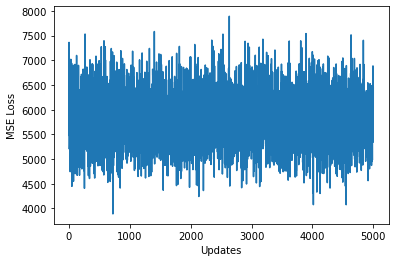

100%|██████████| 5000/5000 [46:23<00:00,  1.80it/s]


In [20]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device="cpu"


seed = 1
set_seed(seed)
results_path = os.path.join('./numerical_results/', "PDE_DGM", "seed{}".format(seed))
if not os.path.exists(results_path):
    os.makedirs(results_path)

train(T=1,
    n_steps=50,
    d=2,
    hidden_dim=100,
    max_updates=5000,
    batch_size=500,
    base_dir=results_path,
    device=device,
    )